<style>
.rendered_html * + p, .rendered_html p {
    text-align:justify;
}
.print {
    display:none;
}
.highlight {
    background:white;
}
@media print {
 a[href]:after {
     content: ""
 }
 .noprint {
  display:none
  }
  .print {
        display:block;
    }
}
</style>
<head>
    <base target="_blank">
</head>


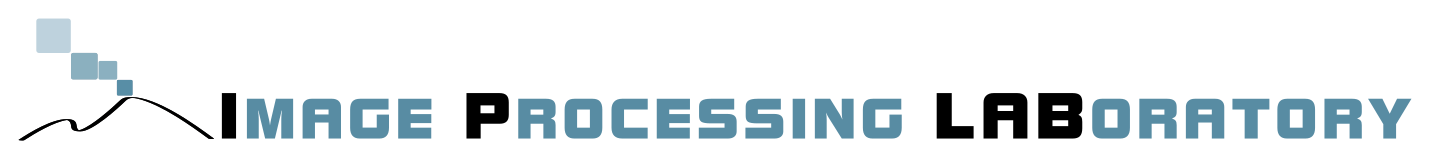

<center><h2>Deep Learning - A.A. 2021-2022</h2></center>
<center><h3>Metric Learning</h3></center>
<br>
<center>Antonino Furnari - <a href="http://www.antoninofurnari.it/" target="_blank">http://www.antoninofurnari.it/</a> - <a href="mailto:furnari@dmi.unict.it">furnari@dmi.unict.it</a> </center>
<center>Giovanni Maria Farinella - <a href="http://www.dmi.unict.it/farinella/" target="_blank">http://www.dmi.unict.it/farinella/</a> - <a href="mailto:gfarinella@dmi.unict.it">gfarinella@dmi.unict.it</a> </center>

In questo laboratorio, vedremo alcuni metodi di deep metric learning. Iniziamo impostanto i seed per riproducibilità:

In [1]:
import torch
import random
import numpy as np

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

NUM_EPOCHS=50

Il metric learning è una tipologia di learning supervisionato che ha come obiettivo quello di apprendere una funzione distanza tra degli elementi. 

Vediamo un esempio. Supponiamo di avere un database contenente immagini di volti $I_i$ con le rispettive etichette $l_i$ che indicano le identità dei soggetti ritratti nelle immagini $l_i$. Il database può essere indicato con $D=\{(I_i, l_i)\}_i^N$. Data una nuova immagine contenente un volto $I_j$ di identità sconosciuta, vorremmo poter "cercare" il nuovo volto all'interno del database al fine di inferire l'identità nel soggetto ritratto nell'immagine. Per poter effettuare questa ricerca, abbiamo bisogno di stimare la distanza tra il nuovo volto $I_j$ e tutti i volti presenti nel database $D$. Alla fine assegneremo al nuovo volto l'etichetta del volto più vicino nel database:

\begin{equation}
\hat l_j = l_{\arg \max_{i} d(I_i, I_j)}
\end{equation}

Dove $d$ è una funzione che misura la distanza tra le immagini di due volti. Questa procedura è una ricerca di tipo nearest neighbour. 

Va notato che la funzione $d$ di cui abbiamo bisogno deve avere determinate caratteristiche. In particolare, vorremmo che la distanza tra due immagini $d(I_i, I_j)$ sia grande nel caso in cui le immagini non ritraggano lo stesso soggetto ($l_i \neq l_j$) e piccola nel caso in cui le identità siano uguali ($l_i = l_j$). Definire questa funzione a mano non è banale. Ad esempio, scegliendo $d$ uguale alla distanza Euclidea, non abbiamo nessuna garanzia che le proprietà richieste vengano rispettate. L'ideale sarebbe apprendere $d$ dai dati, ma non è chiaro come costruire una funzione parametrica $d$ che prende in input due immagini.

Possiamo però vedere il problema in maniera leggermente diversa. Definiamo una funzione $\Phi$ che mappa un'immagine $I$ in uno spazio di dimensionalità limitata ($\Phi$ è simile all'encoder di un autoencoder) e ridefiniamo la funzione distanza come:

\begin{equation}
d(I_i, I_j) = ||\Phi(I_i) - \Phi(I_j)||_2
\end{equation}

Dove $||\Phi(I_i) - \Phi(I_j)||_2$ è la norma L2 del vettore differenza, che equivale a calcolare la distanza Euclidea tra $\Phi(I_i)$ e $\Phi(I_j)$. Se $\Phi$ è una funzione parametrica (es. una CNN), possiamo ottimizzare i parametri di $\Phi$ in maniera tale che $d$ rispetti le caratteristiche richieste. In pratica, stiamo fissando la metrica vera e propria (scegliendo quella Euclidea) e stiamo scegliendo di risolvere un problema leggermente diverso: trovare una funzione $\Phi$ che mappi elementi $I_i$ e $I_j$ della stassa classe ($l_i=l_j$) vicini nello spazio di destinazione ed elementi di classi diverse ($l_i \neq l_j$) lontani tra di loro nello spazio di destinazione.

Esistono diverse tecniche per determinare la funzione $\Phi$ in maniera opportuna. Noi vedremo due possibilità: la rete siamese e la rete triplet.

# 1 Rete Siamese

Il modo più semplice per ottenere una funzione $\Phi$ opportuna consiste nel prevedere una loss che renda la distanza $||\Phi(I_i) - \Phi(I_j)||_2$ piccola se $l_i=l_j$ e grande se $l_i \neq l_j$. Dato che l'espressione $||\Phi(I_i) - \Phi(I_j)||_2$ prende in input due elementi $I_i$ e $I_j$, conviene ragionare su coppie di elementi $(I_i, I_j)$ piuttosto che su elementi singoli. Esistono due tipi di coppie: quelle in cui le etichette dei due elementi sono uguali, e quelle in cui i le due etichette sono diverse. Chiameremo queste coppie "coppie simili" e "coppie dissimili". Assegneremo dunque ad ogni coppia una etichetta $l_{ij}$. In pratica $l_{ij}=0$ se la coppia è "simile", mentre $l_{ij}=1$ se la coppia è "dissimile". Al fine di lavorare su coppie, è possibile utilizzare una rete "siamese", ovvero un'architettura composta da due rami identici che condividono i medesimi pesi che mappano i due elementi della coppia $I_i$ e $I_j$ in due codici $\Phi(I_i)$ e $\Phi(I_j)$. Una volta ottenute queste due rappresentazioni, possiamo applicare una loss opportuna. 

Una rete Siamese può essere rappresentata come mostrato di seguito:

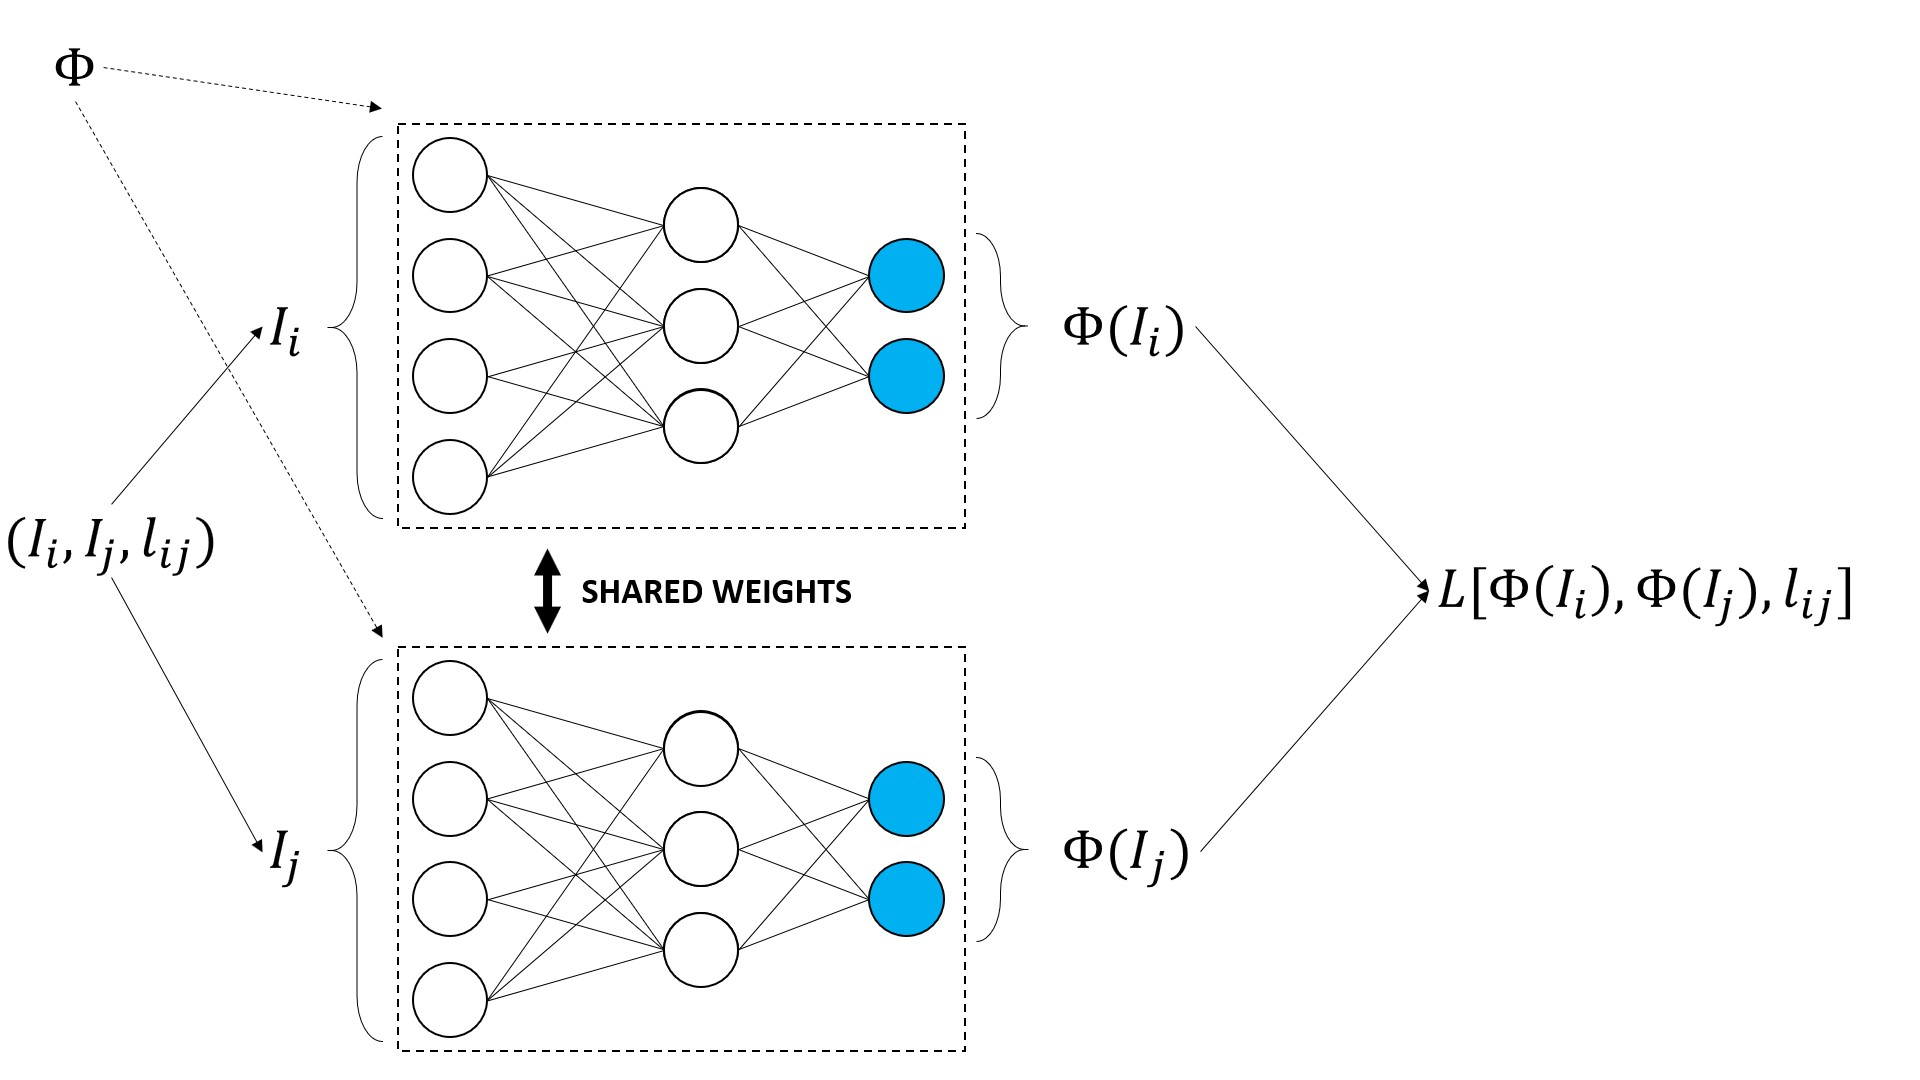

Nel grafico sopra:
 * L'input della rete non è un singolo elemento $I_i$, ma una coppia di elementi con la rispettiva etichetta: $(I_i, I_j, l_{ij})$;
 * La funzione $\Phi$ è rappresentata come un MLP. In pratica $\Phi$ può avere diverse forme, ad esempio $\Phi$ può essere una CNN;
 * I due rami (superiore e inferiore) hanno pesi condivisi. Ciò vuole dire che ogni volta il valore di uno dei pesi in una delle due reti viene aggiornato, esso viene aggiornato anche nell'altra rete;
 * I pallini azzurri rappresentano i due codici $\Phi(I_i)$ e $\Phi(I_j)$;
 * La loss utilizzata per allenare la rete $L[\Phi(I_i), \Phi(I_j),l_i,l_j]$ dipende sia dai due codici che dalle due etichette.
 
Diverse funzioni di loss sono possibili. In pratica, la loss più utilizzata è la contrastive loss, che viene definita come segue per una data coppia in input:

\begin{eqnarray}
d(I_i, I_j) = ||\Phi(I_i)-\Phi(I_j)||_2 \\
L(I_i, I_j, l_{ij}) = \frac{1}{2}(1-l_{ij})d(I_i, I_j)^2+\frac{1}{2}l_{ij}\{max[0,m-d(I_i, I_j)]\}^2
\end{eqnarray}

dove $m$ è un parametro della loss detto "margine". La loss assomiglia a una binary cross entropy. Analizziamola:
 * Se la coppia è di tipo "simile", allora $l_{ij}=0$. In tal caso, $L(I_i,I_j,1) = \frac{1}{2}d(I_i,I_j)^2$, che risulta minimizzata quando $d(I_i, I_j)$ è piccola. Pertanto, in questo caso, $\Phi$ viene incoraggiata a mappare i due elementi in posizioni vicine tra di loro nello spazio di destinazione;
 * Se la coppia è di ditpo "dissimile", allora $l_{ij}=1$. In tal caso, $L(I_i,I_j,0) = \frac{1}{2}\{max([0, m-d(I_i, I_j)]\}^2$. Abbiamo adesso due casi:
    * $d(I_i, I_j)>m$: in tal caso $m-d(I_i, I_j)<0$ e $L(I_i,I_j,0)=0$. Pertanto, se la distanza $d(I_i, I_j)$ è superiore al margine $m$, la rete non viene penalizzata in quanto si ritiene che i due mapping sono già abbastanza lontani;
    * $d(I_i, I_j)<m$: in tal caso $m-d(I_i, I_j)>0$ e $L(I_i,I_j,0)=(m-d(I_i,I_j))^2$, e la rete riceve una penalità quadratica rispetto alla differenza tra la distanza e il margine. Se la distanza è molto piccola, la penalità sarà maggiore, se è abbastanza vicina a $m$, la penalità sarà minore.
    
In pratica, il margine $m$ stabilisce la distanza minima tra due elementi diversi nello spazio di destinazione. Esistono diversi tecniche per impostare il valore del margine. Per semplicità, in questo laboratorio imposteremo $m=2$, che è un valore comunemente usato.

# 1.1 Dataset
 
Per costruire la nostra rete Siamese, abbiamo innanzitutto bisogno di costruire un oggetto dataset che restituisca coppie di immagini con le rispettive etichette. Vedremo un semplice esempio relativo al dataset MNIST. Le nostre coppie saranno dunque composte da due immagini rappresentanti cifre. L'etichetta relativa sarà pari a $0$ se le etichette delle due immagini sono uguali e $1$ altrimenti. Costruiremo un oggetto database che ha tanti elementi quanti sono gli elementi di MNIST. A ciascun elemento verrà associato un elemento simile o dissimile con probabilità $\frac{1}{2}$. Ciò ci permetterà di avere un dataset di coppie bilanciato.

In [2]:
from torch.utils import data

class PairMNIST(data.Dataset):
    def __init__(self, root, train = True, transform = None, download = True):
        self.mnist = MNIST(root = root, train = train, transform = transform, download = download)
        
        #lista di liste che contiene gli indici delgi elementi appartenenti alle singole classi
        #in pratica class_to_indices[5] contiene gli indici degli elementi di classe 5
        self.class_to_indices = [np.where(self.mnist.targets == label)[0] for label in range(10)]

        #genera le coppie
        self.generate_pairs()
        
    def generate_pairs(self):
        """Genera le coppie, associando ad ogni elemento di
        MNIST un nuovo elemento"""
        #creiamo un vettore di etichette delle coppie
        self.pair_labels = (np.random.rand(len(self.mnist))>0.5).astype(int)
        
        #paired_idx conterrà i secondi elementi delle coppie
        #il primo elmento della coppia i-esima sarà sempre
        #l'elemento i-esimo di MNIST
        self.paired_idx = []
        #scorriamo le etichette delle coppie
        for i, l in enumerate(self.pair_labels):
            #otteniamo la classe del primo elemento della coppia
            c1 = self.mnist.targets[i].item()
            if l==0: #se la coppia è di tipo simile
                #scegli un elemento della stessa classe
                j = np.random.choice(self.class_to_indices[c1])
            else: #altrimenti
                #scegli un elemento di classe diversa
                #scegliamo una classe diversa a caso
                diff_class = np.random.choice(list(set(range(10))-{c1}))
                #campioniamo da quella classe
                j = np.random.choice(self.class_to_indices[diff_class])
            #conserviamo l'indice del secondo elemento della coppia
            self.paired_idx.append(j)
        
    def __len__(self):
        #tante coppie quanti sono gli elemnti di MNIST
        return len(self.mnist)
    
    def __getitem__(self, i):
        #la prima immagine della coppia
        #è l'elemento i-esimo di MNIST
        im1, l1 = self.mnist[i]
        im2, l2 = self.mnist[self.paired_idx[i]] #secondo elemento associato
        l = self.pair_labels[i] #etichetta della coppia
        
        #restituiamo le due immagini, l'etichetta della coppia
        #e le etichette delle due immagini
        return im1, im2, l, l1, l2

Costruiamo il dataset e visualizziamo qualche coppia di esempio:

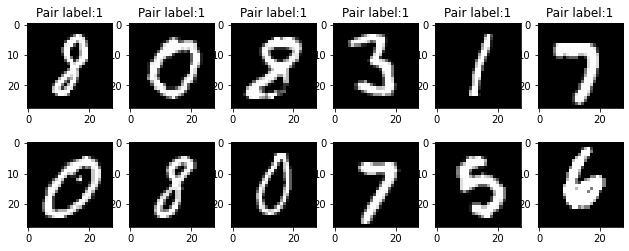

In [3]:
from matplotlib import pyplot as plt
from torchvision.datasets import MNIST
pair_mnist_train = PairMNIST('mnist', train=True)
plt.figure(figsize=(18,4))
for ii,i in enumerate(np.random.choice(range(len(pair_mnist_train)),6)):
    plt.subplot(2,10,ii+1)
    plt.title('Pair label:'+str(pair_mnist_train[i][2]))
    plt.imshow(pair_mnist_train[i][0], cmap='gray')
    plt.subplot(2,10,ii+11)
    plt.imshow(pair_mnist_train[i][1], cmap='gray')
plt.show()

<div>
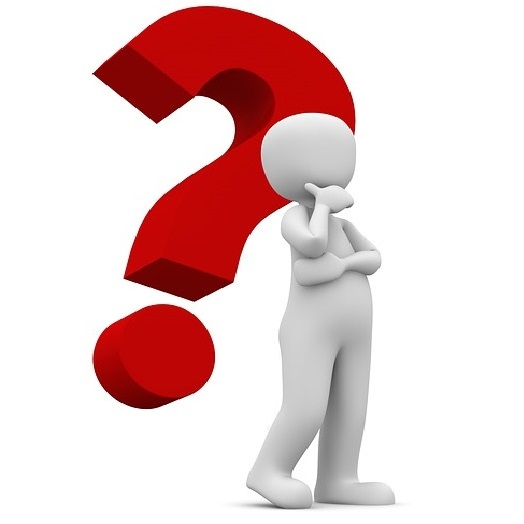
</div>

**Domanda 1**

Si osservino le coppie rappresentate nelle colonne. Ha senso dire che elementi in coppie positive sono in genere più simili di elementi in coppie negative?

<div>
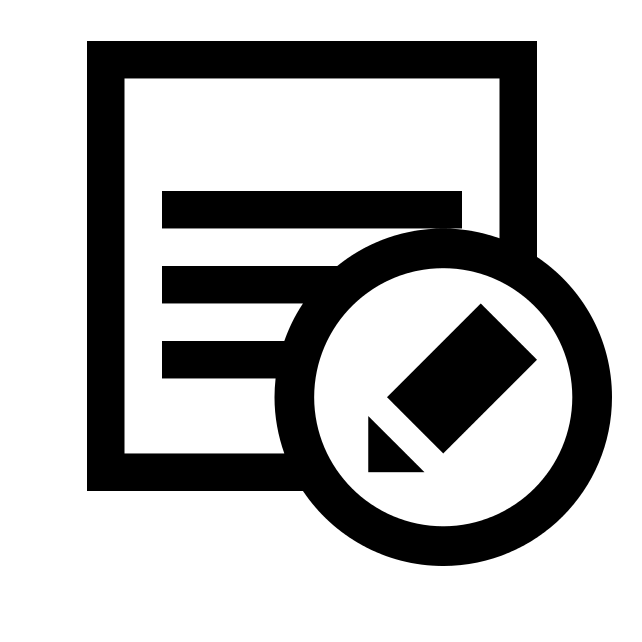
</div>

**Risposta 1**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

## 1.2 Modello
Implementiamo $\Phi$ basandoci su LeNet. Dato che non useremo $\Phi$ per classificare i dati in input, ometteremo l'ultimo livello con $10$ unità. Chiameremo questa rete `EmbeddingNet` in quanto il suo ruolo è quello di ottenere degli embedding (o codici) delle immagini in input:

In [4]:
from torch import nn
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), 
                                     nn.ReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.BatchNorm2d(32),
                                     nn.Conv2d(32, 64, 5), 
                                     nn.ReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.BatchNorm1d(64 *4 * 4),
                                nn.Linear(64 * 4 * 4, 256),
                                nn.ReLU(),
                                nn.BatchNorm1d(256),
                                nn.Linear(256, 128))

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

Verifichiamo che l'output sia quello desiderato con un batch fittizio:

In [5]:
model = EmbeddingNet()
model(torch.zeros(16,1,28,28)).shape

torch.Size([16, 128])

## 1.3 Funzione di loss
Prima di effettuare il training, dobbiamo implementare la funzione di loss. Ricordiamo che la loss per un dato campione è definita come segue:

\begin{eqnarray}
d(I_i, I_j) = ||\Phi(I_i)-\Phi(I_j)||_2 \\
L(I_i, I_j, l_{ij}) = \frac{1}{2}(1-l_{ij})d(I_i, I_j)^2+\frac{1}{2}l_{ij}\{max[0,m-d(I_i, I_j)]\}^2
\end{eqnarray}

In [6]:
from torch.nn import functional as F

class ContrastiveLoss(torch.nn.Module):
    def __init__(self, m=2):
        super(ContrastiveLoss, self).__init__()
        self.m = m

    def forward(self, phi_i, phi_j, l_ij):
        d = F.pairwise_distance(phi_i, phi_j)
        l = 0.5 * (1 - l_ij.float()) * torch.pow(d,2) + \
            0.5 * l_ij.float() * torch.pow( torch.clamp( self.m - d, min = 0) , 2)
        return l.mean()

dove `F.pairwise_distance(x,y)` calcola la distanza euclidea tra tutti gli elementi di $x$ e tutti gli elementi di $y$ quando $x$ e $y$ sono dei batch, `torch.pow(x,2)` implementa $x^2$ e `torch.clamp(x, min=0)` implementa `min(x,o)`.

## 1.4 Training del modello
Adesso che abbiamo tutti gli elementi necessari, definiamo un modulo di PyTorch Lightning che ci permetta di fare training della rete siamese. Per monitorare lo stato di training della rete in termini qualitativi, alla fine di ogni epoca stamperemo l'embedding del primo batch di test.

In [7]:
import pytorch_lightning as pl
import itertools
from torch.utils.data import DataLoader
import torchvision
from torch.optim import SGD

class SiameseNetworkTask(pl.LightningModule):
    def __init__(self, 
                 embedding_net, # la rete di embedding
                 lr=0.01, # il learning rate
                 momentum=0.99, # momentum
                 margin=2 # margine per la loss
                ):
        super(SiameseNetworkTask, self).__init__()
        self.save_hyperparameters()
        self.embedding_net = embedding_net
        self.criterion = ContrastiveLoss(margin) #definiamo la loss
                    
    def forward(self, x):
        return self.model(x)
        
    def configure_optimizers(self):
        return SGD(self.embedding_net.parameters(), self.hparams.lr, momentum=self.hparams.momentum)
    
    def training_step(self, batch, batch_idx):
        # preleviamo gli elementi I_i e I_j e l'etichetta l_ij
        # scartiamo il resto (le etichette dei singoli elementi)
        I_i, I_j, l_ij, *_ = batch
        
        #l'implementazione della rete siamese è banale:
        #eseguiamo la embedding net sui due input
        phi_i = self.embedding_net(I_i)
        phi_j = self.embedding_net(I_j)

        #calcoliamo la loss
        l = self.criterion(phi_i, phi_j, l_ij)
        
        self.log('train/loss', l)
        return l
    
    def validation_step(self, batch, batch_idx):
        I_i, I_j, l_ij, *_ = batch
        phi_i = self.embedding_net(I_i)
        phi_j = self.embedding_net(I_j)
        l = self.criterion(phi_i, phi_j, l_ij)
        self.log('valid/loss', l)
        
        if batch_idx==0:
            self.logger.experiment.add_embedding(phi_i, batch[3], I_i, global_step=self.global_step)

Costruiamo dataset e data loaders:

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))]) 
pair_mnist_train = PairMNIST(root='mnist',train=True, download=True, transform=transform)
pair_mnist_test = PairMNIST(root='mnist',train=False, download=True, transform=transform)
pair_mnist_train_loader = DataLoader(pair_mnist_train, batch_size=1024, num_workers=8, shuffle=True)
pair_mnist_test_loader = DataLoader(pair_mnist_test, batch_size=1024, num_workers=8)

Costruiamo e alleniamo il modello:

In [9]:
from pytorch_lightning.loggers import TensorBoardLogger

siamese_mnist_task = SiameseNetworkTask(EmbeddingNet())
logger = TensorBoardLogger("metric_logs", name="siamese_mnist")
trainer = pl.Trainer(gpus=1, logger=logger, max_epochs=NUM_EPOCHS, enable_progress_bar=False)

trainer.fit(siamese_mnist_task, pair_mnist_train_loader, pair_mnist_test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name          | Type            | Params
--------------------------------------------------
0 | embedding_net | EmbeddingNet    | 350 K 
1 | criterion     | ContrastiveLoss | 0     
--------------------------------------------------
350 K     Trainable params
0         Non-trainable params
350 K     Total params
1.400     Total estimated model params size (MB)


Alla fine della procedura di training, i grafici su tensorboard avranno un aspetto simile a questo:

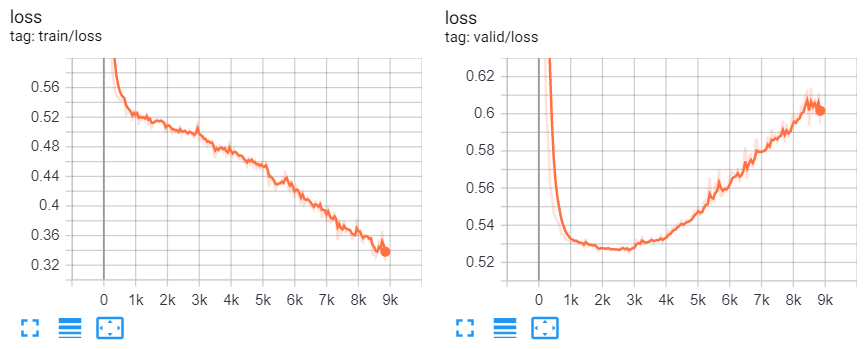

Cliccando su "projector" possiamo visualizzare un embedding 3D creato in automatico dai dati di cui abbiamo fatto log. Selezioniamo l'ultimo tensore disponibile (quello relativo all'ultima epoca) nel secondo menù a tendina a sinistra ("x tensors found"), ad esempio, selezioniamo `default:01061`. Selezioniamo poi `label` in `Color by`.

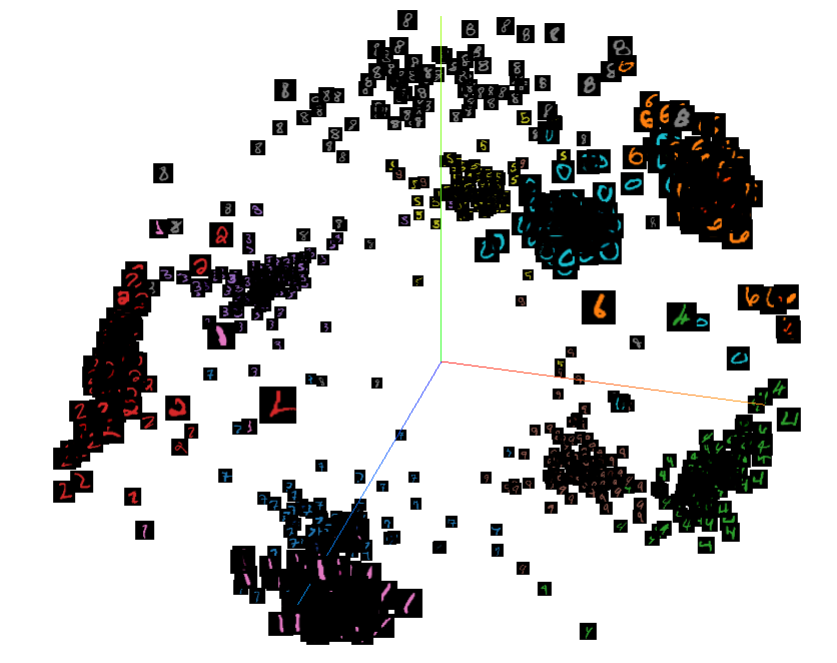

<div>
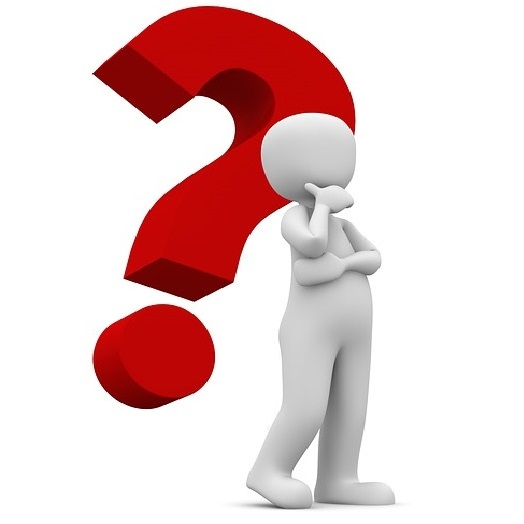
</div>

**Domanda 2**

Si esplori il grafico ottenuto in tensorboard. Gli embedding ottenuti sono buoni?

<div>
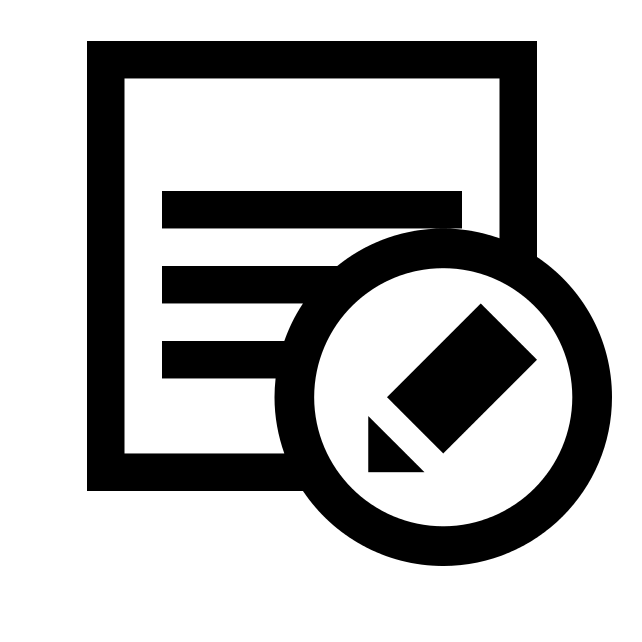
</div>

**Risposta 2**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Come visto nel caso degli autoencoders, possiamo adesso utilizzare la rete per estrarre le rappresentazioni di ciascuna immagine del dataset:

In [10]:
def extract_representations(model, loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    model.to(device)
    representations, labels = [], []
    for batch in loader:
        x = batch[0].to(device)
        rep = model(x)
        rep = rep.detach().to('cpu').numpy()
        labels.append(batch[1])
        representations.append(rep)
    return np.concatenate(representations), np.concatenate(labels)

In [11]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))]) 

mnist_test_loader = DataLoader(MNIST(root='mnist',train=False, download=True, transform=transform), num_workers=8, batch_size=1024)
mnist_test_representations, mnist_test_labels = extract_representations(siamese_mnist_task.embedding_net, mnist_test_loader)

Utilizziamo dunque TSNE per visualizzare gli embedding di acluni esempi:

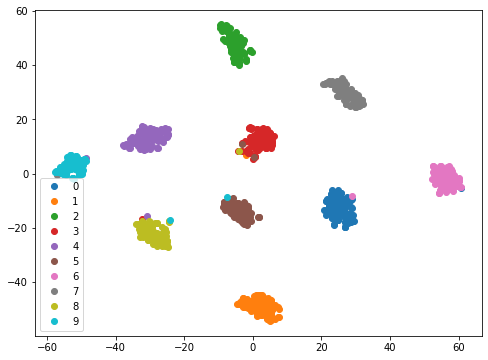

In [12]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
selected_rep = np.random.choice(len(mnist_test_representations),1000)
selected_mnist_test_representations = mnist_test_representations[selected_rep]
selected_mnist_test_labels = mnist_test_labels[selected_rep]

tsne = TSNE(2)
rep_tsne=tsne.fit_transform(selected_mnist_test_representations)

plt.figure(figsize=(8,6))
for c in np.unique(selected_mnist_test_labels):
    plt.plot(rep_tsne[selected_mnist_test_labels==c, 0], rep_tsne[selected_mnist_test_labels==c, 1], 'o', label = c)
plt.legend()
plt.show()

<div>
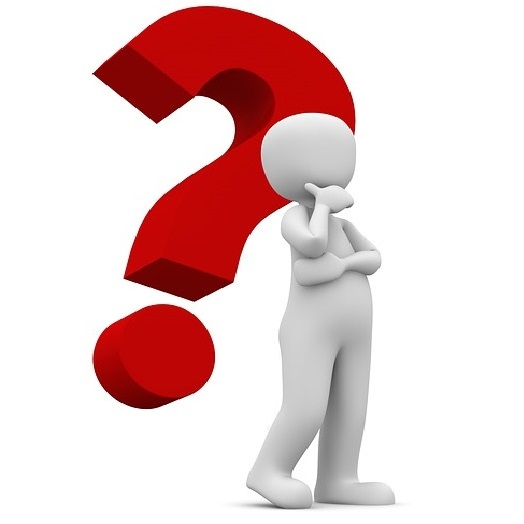
</div>

**Domanda 3**

Si commenti il grafico ottenuto. Le rappresentazioni ottenute sono buone per risolvere task di classificazione?

<div>
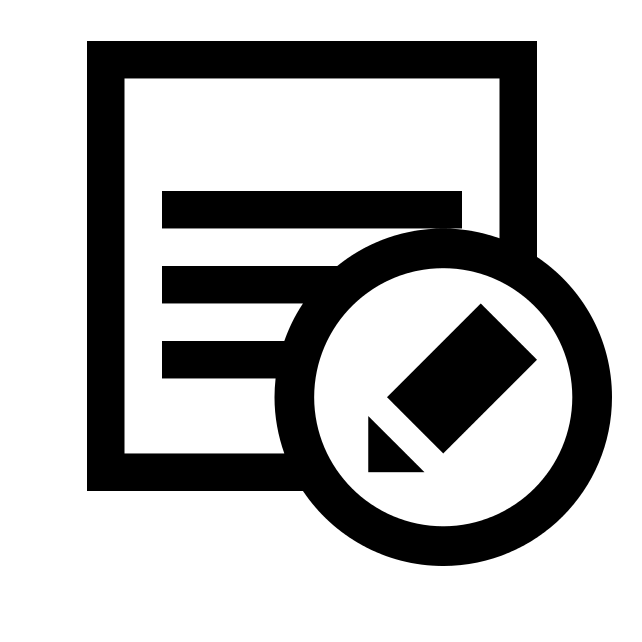
</div>

**Risposta 3**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

# 2 Rete Triplet

La rete Siamese viene allenata includendo all'interno dello stesso batch sia esempi negativi che esempi positivi. Se includessimo solo esempi positivi, la rete imparerebbe a mappare qualsiasi input sullo stesso punto, in modo da ottenere sempre distanza nulla. Se includessimo solo esempi negativi, al contrario, la rete cercherebbe di mappare i nuovi campioni sempre lontani rispetto ai campioni già visti. Una rete di tipo Triplet estende l'idea di avere coppie positive e negative lavorando su triplette invece che su coppia. 

Ogni tripletta $(I_i, I_j, I_k)$ contiene tre elementi:
 * Un'ancora $I_i$, ovvero un elemento di classe qualsiasi;
 * Un esempio positivo $I_j$, ovvero un elemento della stessa classe di $I_i$;
 * Un esempio negativo $I_k$, ovvero un elemento di classe diversa rispetto a $I_i$ e $I_j$.

Ogni elemento in input presenta dunque un esempio positivo (la coppia ($I_i, I_j$)) e un esempio negativo (la coppia ($I_i, I_k$)). A differenza per quanto avveniva nel caso delle reti siamesi, le triplette non hanno una etichetta associata. Il modello viene dunque allenato facendo sì che $I_i$ venga mappato vicino a $I_j$ ma allo stesso tempo lontano da $I_k$. Ciò costituisce un criterio di training più forte rispetto a quello delle reti siamesi. Infatti, mentre le caso delle reti siamesi le coppie positive e negative potevano non avere alcuna relazione tra di esse, le triplette offrono sempre un esempio positivo e un esempio negativo relativi al medesimo elemento ancora $I_i$. 

Una rete Triplet può essere rappresentata come segue:

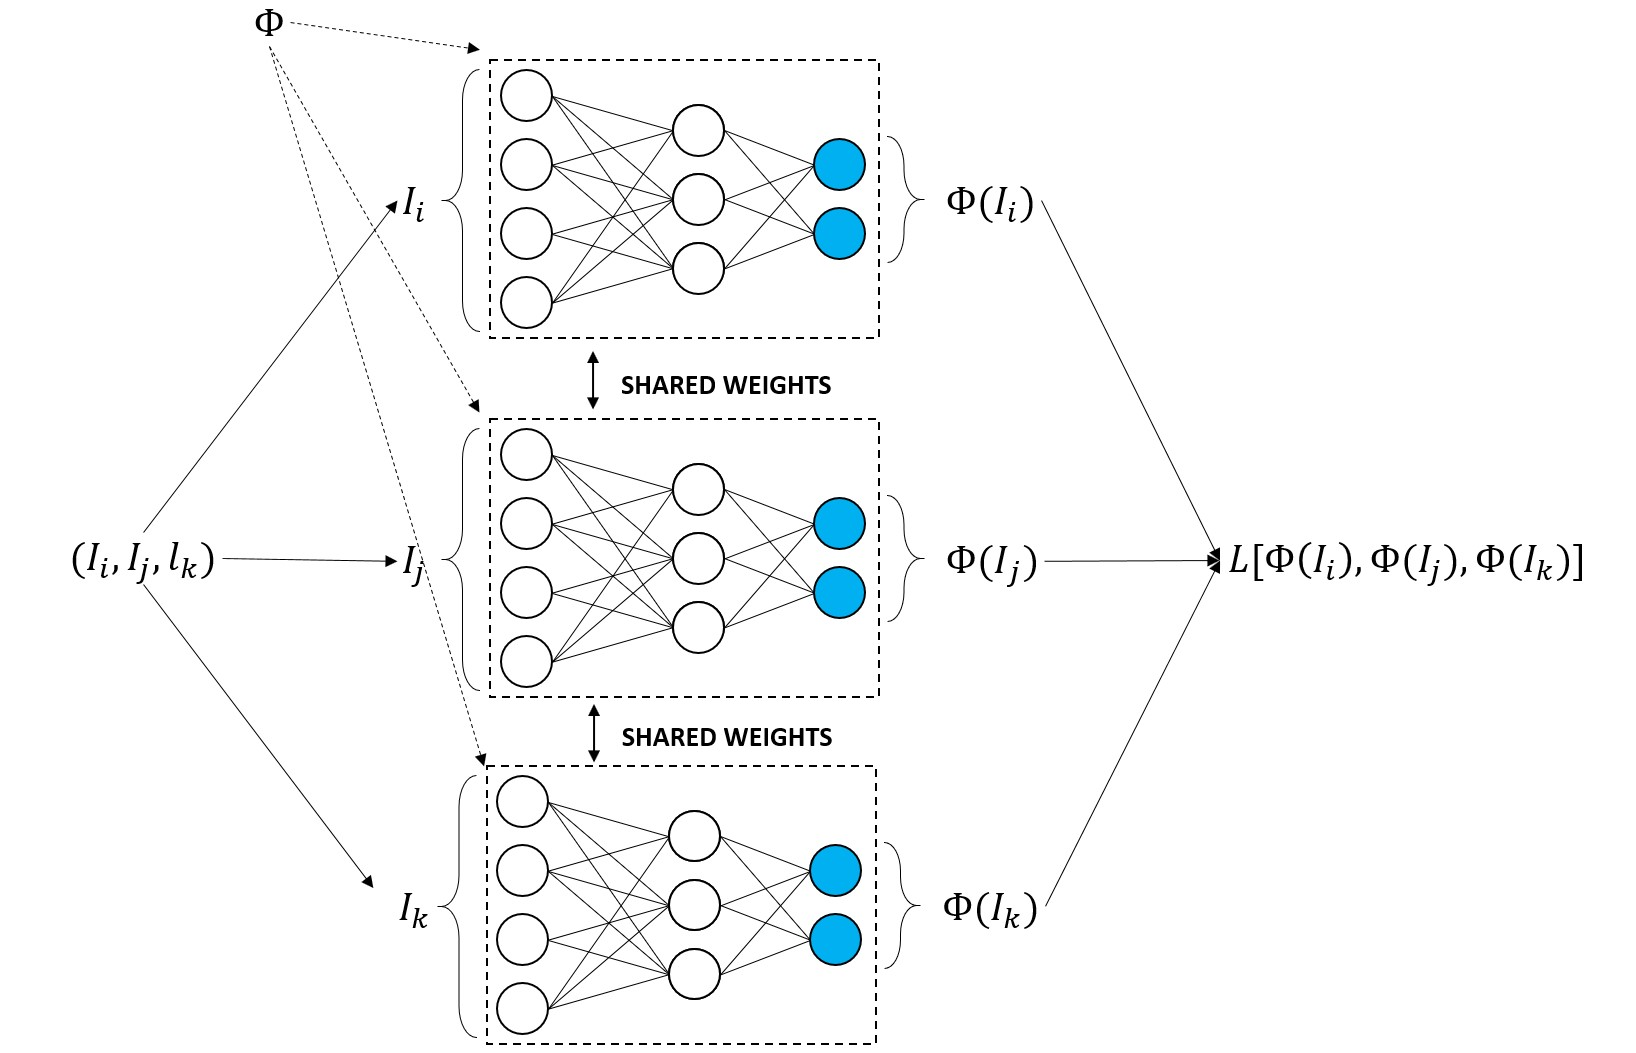

Anche in questo caso i pesi delle tre reti sono condivisi. Esistono diversi tipi di loss, ma la più comune è la Triplet margin loss, definita come segue:

\begin{eqnarray}
d(I_i, I_j) = ||\Phi(I_i) - \Phi(I_j)||_2 \\
L(I_i, I_j, I_k) = \max\{d(I_i, I_j)-d(I_i, I_k)+m, 0\}
\end{eqnarray}

In maniera simile a quanto visto nel caso della contrastive loss, $m$ è un margine. In questo laboratorio imposteremo $m=1$.

La loss scritta sopra incoraggia la rete $\Phi$ a mappare l'elemento simile $I_j$ vicino all'elemento $I_i$ e al contempo, l'elemento $I_k$ lontano da $I_i$. Ciò avviene penalizzando la rete ogni volta che $d(I_i, I_j)$ non è maggiore di $d(I_i, I_k)$ di un valore almeno pari ad $m$. Abbiamo infatti due casi:
 * $d(I_i, I_j) + m <=d(I_i, I_k)$: in questo caso $d(I_i, I_j)-d(I_i, I_k)+m<0$ e $L(I_i, I_j, I_k)=0$. In pratica il modello non viene penalizzato in quanto la distanza tra l'ancora $I_i$ e l'elemento simile $I_j$ è già sufficientemente inferiore (ovver inferiore di almento $m$) alla distanza tra l'ancora $I_i$ e l'elemento dissimile $I_k$;
 * $d(I_i, I_k) +m >d(I_i, I_k)$: in questo caso $d(I_i, I_j)-d(I_i, I_k)+m>0$ e $L(I_i, I_j, I_k)=d(I_i, I_j)-d(I_i, I_k)+m$. Pertanto il modello riceve una penalità (una loss positiva) in quanto non vi è abbastanza margine tra le due distanze. La loss è tanto più alta quanto questo margine è grande.
 
Questa funzione di loss è già implementata in PyTorch da modulo `nn.TripletMarginLoss`, che utilizzeremo per i nostri esperimenti.

## 2.1 Dataset

Dobbiamo implementare un dataset che restituisca delle triplette di valori. L'implementazione è analoga a quanto visto nel caso delle reti siamesi:

In [13]:
class TripletMNIST(data.Dataset):
    def __init__(self, root, train = True, transform = None, download = True):
        self.mnist = MNIST(root = root, train = train, transform = transform, download = download)
        
        #lista di liste che contiene gli indici elementi appartenenti alle singole classi
        #in pratica class_to_indices[5] contiene gli indici degli elementi di classe 5
        self.class_to_indices = [np.where(self.mnist.targets == label)[0] for label in range(10)]

        #genera le triplette
        self.generate_triplets()
        
    def generate_triplets(self):
        """Genera le triplette, associando ad ogni elemento di
        MNIST due nuovi elementi: uno simile e uno dissimile"""
        
        #similar_idx conterrà i secondi elementi delle triplette
        #dissimilar_idx conterrà i terzi elementi delle triplette
        #il primo elmento della coppia i-esima sarà sempre
        #l'elemento i-esimo di MNIST
        self.similar_idx = []
        self.dissimilar_idx = []
        #scorriamo gli elementi di MNIST
        for i in range(len(self.mnist)):
            #classe del primo elemento della tripletta
            c1 = self.mnist.targets[i].item()
            #indice dell'elemento simile
            j = np.random.choice(self.class_to_indices[c1])
            
            #scegliamo una classe diversa a caso
            diff_class = np.random.choice(list(set(range(10))-{c1}))
            #campioniamo da quella classe per ottenere l'indice dell'elemento dissimile
            k = np.random.choice(self.class_to_indices[diff_class])
            
            self.similar_idx.append(j)
            self.dissimilar_idx.append(k)
        
    def __len__(self):
        #tante triplette quanti sono gli elemnti di MNIST
        return len(self.mnist)
    
    def __getitem__(self, i):
        #la prima immagine della coppia
        #è l'elemento i-esimo di MNIST
        im1, l1 = self.mnist[i]
        im2, l2 = self.mnist[self.similar_idx[i]] #elemento simile
        im3, l3 = self.mnist[self.dissimilar_idx[i]] #elemento dissimile
        
        #restituiamo le due immagini, l'etichetta della coppia
        #e le etichette delle due immagini
        return im1, im2, im3, l1, l2, l3

Costruiamo il dataset e visualizziamo qualche tripletta di esempio:

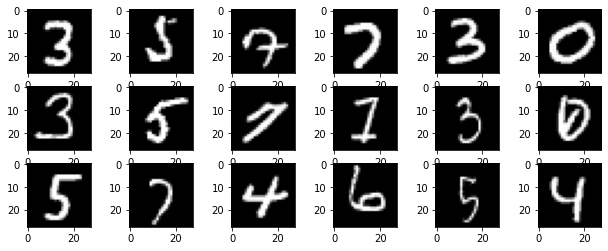

In [14]:
triplet_mnist_train = TripletMNIST('mnist', train=True)
plt.figure(figsize=(18,4))
for ii,i in enumerate(np.random.choice(range(len(triplet_mnist_train)),6)):
    plt.subplot(3,10,ii+1)
    plt.imshow(triplet_mnist_train[i][0], cmap='gray')
    plt.subplot(3,10,ii+11)
    plt.imshow(triplet_mnist_train[i][1], cmap='gray')
    plt.subplot(3,10,ii+21)
    plt.imshow(triplet_mnist_train[i][2], cmap='gray')
plt.show()

<div>
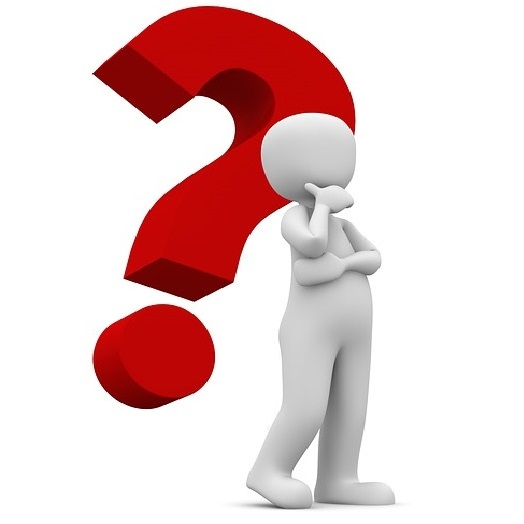
</div>

**Domanda 4**

Si confrontino e commentino le triplette visualizzate qui con le coppie mostrate nel caso della rete siamese. Che vantaggio hanno le triplette rispetto alle coppie viste in precedenza?

<div>
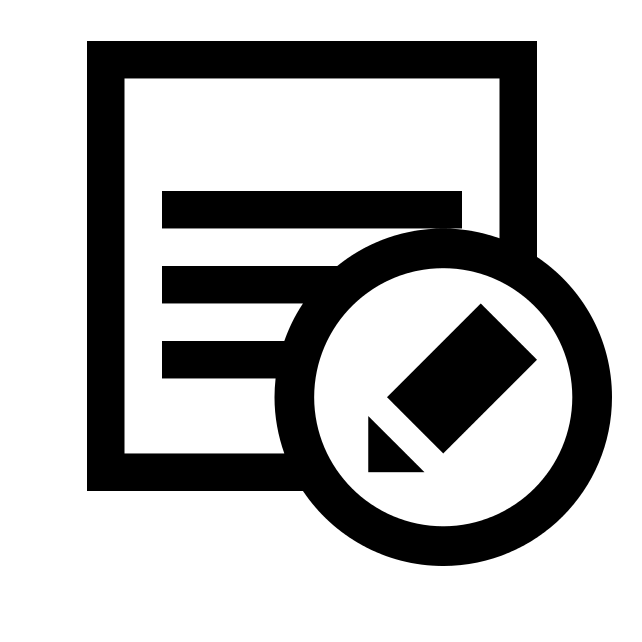
</div>

**Risposta 4**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

## 2.2 Training

Definiamo una procedura di training analoga a quella vista nel caso delle reti siamesi. Anche in questo caso plotteremo gli embedding durante il training.

In [15]:
class TripletNetworkTask(pl.LightningModule):
    def __init__(self, 
                 embedding_net, # la rete di embedding
                 lr=0.01, # il learning rate
                 momentum=0.99, # momentum
                 margin=2 # margine per la loss
                ):
        super(TripletNetworkTask, self).__init__()
        self.save_hyperparameters()
        self.embedding_net = embedding_net
        self.criterion = nn.TripletMarginLoss(margin = margin)
                    
    def forward(self, x):
        return self.model(x)
        
    def configure_optimizers(self):
        return SGD(self.embedding_net.parameters(), self.hparams.lr, momentum=self.hparams.momentum)
    
    def training_step(self, batch, batch_idx):
        I_i, I_j, I_k, *_ = batch
        #l'implementazione della rete triplet è banale quanto quella della rete siamese:
        #eseguiamo la embedding net sui tre input
        phi_i = self.embedding_net(I_i)
        phi_j = self.embedding_net(I_j)
        phi_k = self.embedding_net(I_k)

        #calcoliamo la loss
        l = self.criterion(phi_i, phi_j, phi_k)
        
        self.log('train/loss', l)
        return l
    
    def validation_step(self, batch, batch_idx):
        I_i, I_j, I_k, *_ = batch
        phi_i = self.embedding_net(I_i)
        phi_j = self.embedding_net(I_j)
        phi_k = self.embedding_net(I_k)

        #calcoliamo la loss
        l = self.criterion(phi_i, phi_j, phi_k)
        self.log('valid/loss', l)
        
        if batch_idx==0:
            self.logger.experiment.add_embedding(phi_i, batch[3], I_i, global_step=self.global_step)

Definiamo i dataloader di training e test:

In [16]:
triplet_mnist_train = TripletMNIST('mnist', train=True, transform=transform)
triplet_mnist_test = TripletMNIST('mnist', train=False, transform=transform)

triplet_mnist_train_loader = DataLoader(triplet_mnist_train, batch_size=1024, shuffle=True, num_workers=8)
triplet_mnist_test_loader = DataLoader(triplet_mnist_test, batch_size=1024, num_workers=8)

Effettuiamo adesso il training:

In [17]:
from pytorch_lightning.loggers import TensorBoardLogger

triplet_mnist_task = TripletNetworkTask(EmbeddingNet())
logger = TensorBoardLogger("metric_logs", name="triplet_mnist")
trainer = pl.Trainer(gpus=1, logger=logger, max_epochs=NUM_EPOCHS, progress_bar_refresh_rate=0)

trainer.fit(triplet_mnist_task, triplet_mnist_train_loader, triplet_mnist_test_loader)

/home/furnari/miniconda3/envs/dl/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name          | Type              | Params
----------------------------------------------------
0 | embedding_net | EmbeddingNet      | 350 K 
1 | criterion     | TripletMarginLoss | 0     
----------------------------------------------------
350 K     Trai

Alla fine del training otterremo dei grafici di questo tipo:

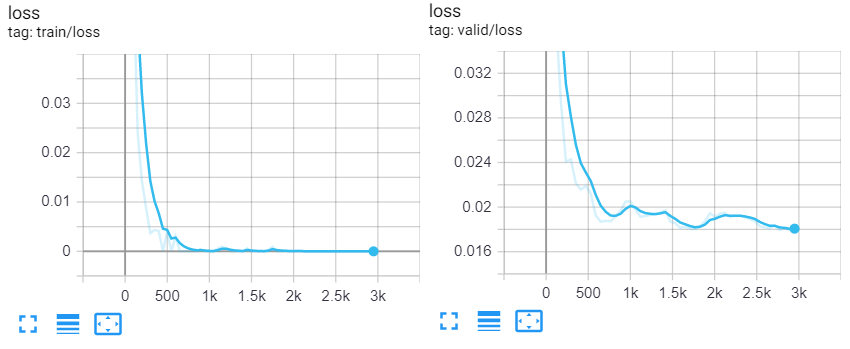

E un grafico di embedding di questo tipo:

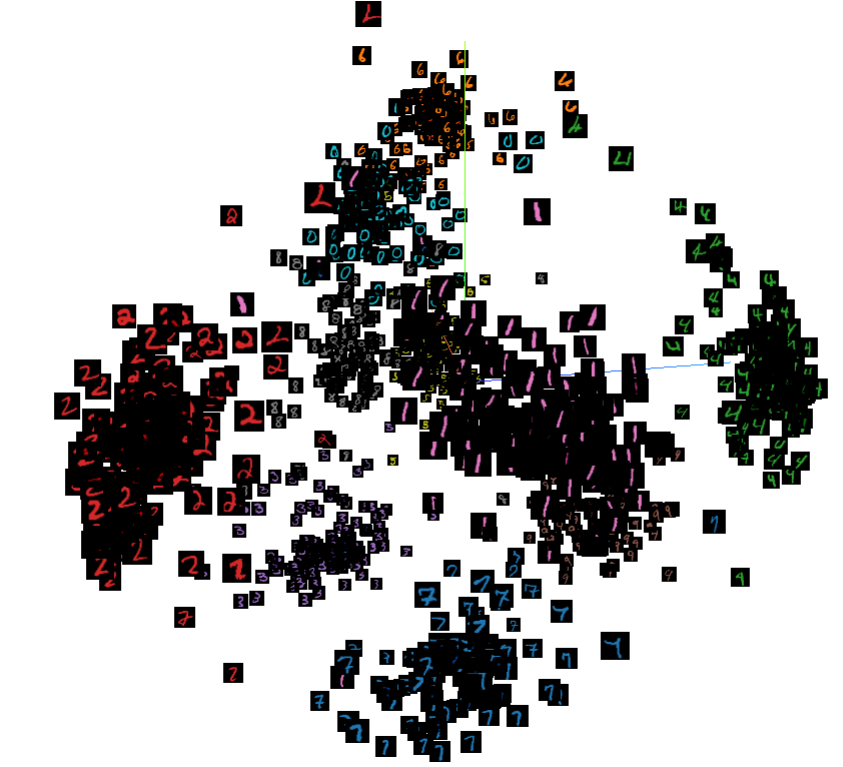

Come nel caso della rete siamese, possiamo estrarre le rappresentazione e stampare i valori a schermo:

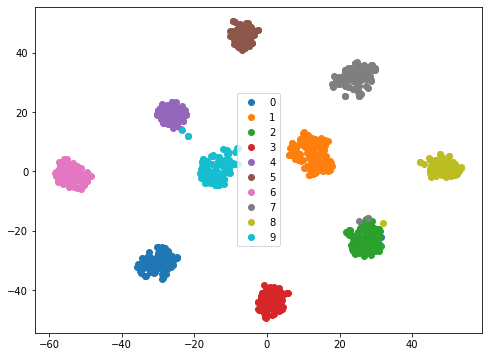

In [18]:
mnist_test_representations, mnist_test_labels = extract_representations(triplet_mnist_task.embedding_net, mnist_test_loader)
selected_rep = np.random.choice(len(mnist_test_representations),1000)
selected_mnist_test_representations = mnist_test_representations[selected_rep]
selected_mnist_test_labels = mnist_test_labels[selected_rep]

tsne = TSNE(2)
rep_tsne=tsne.fit_transform(selected_mnist_test_representations)

plt.figure(figsize=(8,6))
for c in np.unique(selected_mnist_test_labels):
    plt.plot(rep_tsne[selected_mnist_test_labels==c, 0], rep_tsne[selected_mnist_test_labels==c, 1], 'o', label = c)
plt.legend()
plt.show()

<div>
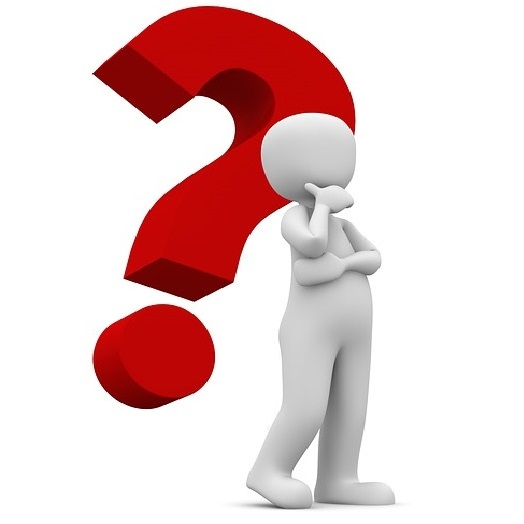
</div>

**Domanda 5**

Si confrontino gli embedding ottenuti mediante la rete triplet con quelli ottenuti mediante la rete siamese. Ci sono differenze?

<div>
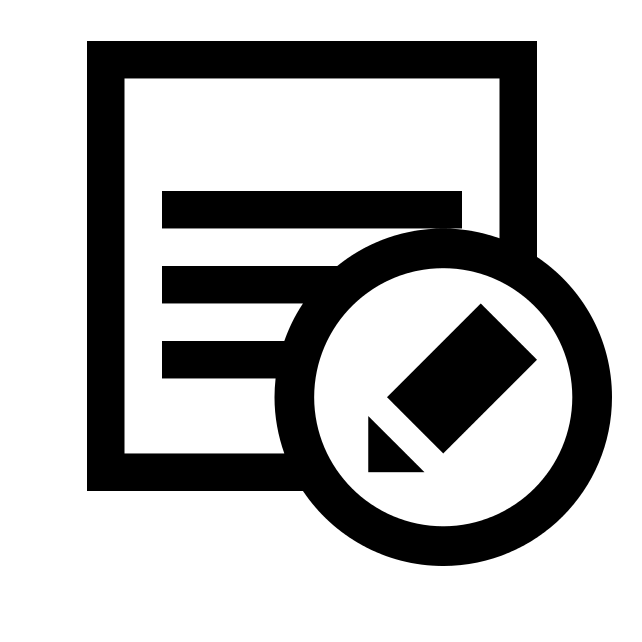
</div>

**Risposta 5**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

# 3 Metric Learning per la localizzazione basata su immagini

Vediamo adesso un esempio concreto di uso del metric learning per risolvere il problema della localizzazione basata su immagini. In questo esempio, tratteremo il problema della localizzazione com un problema di image retrieval. Assumeremo di avere a disposizione un insieme di immagini associate alle posizioni in cui queste immagini sono state acquisite in un sistema di riferimento. Utilizzeremo parte di questi dati come spazio di ricerca (o training set). Data una nuova immagine, cercheremo dunque all'interno del training set l'immagine più simile e restituiremo la sua posizione come stima della posizione dell'immagine di input. Questo approccio è riassunto nell'immagine seguente:

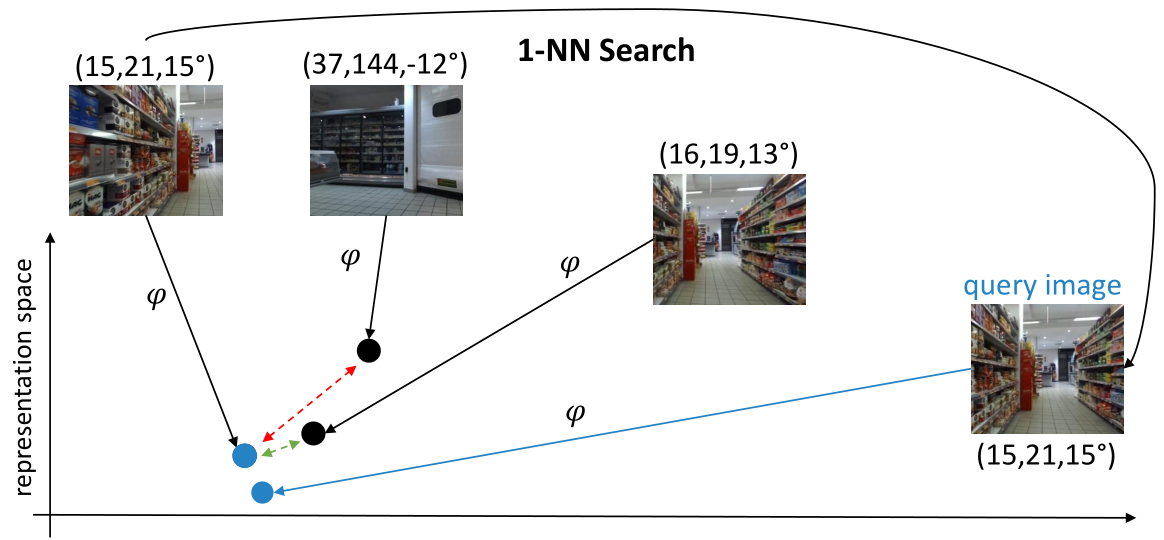

Nello schema sopra, $\phi$ rappresenta una funzione utilizzata per rappresentare le immagini in modo da poterle proiettare in uno spazio di rappresentazione nel quale effettuare la ricerca.

<div>
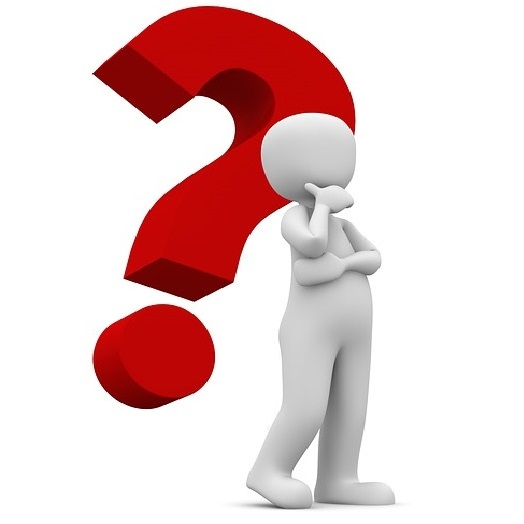
</div>

**Domanda 6**

Che caratteristiche deve avere la funzione di rappresentazione $\phi$? Il metric learning può essere d'aiuto? Perché?

<div>
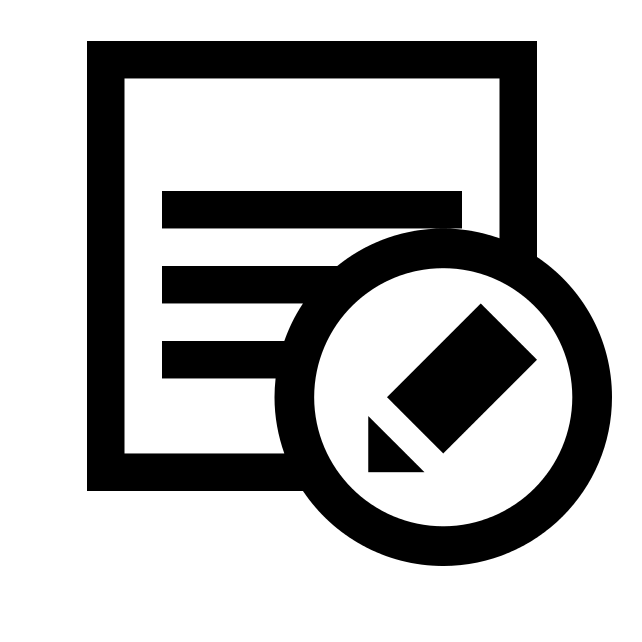
</div>

**Risposta 6**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

## 3.1 Dataset
Per questo esempio, utilizzeremo il dataset EgoCart disponibile a questa pagina: https://iplab.dmi.unict.it/EgocentricShoppingCartLocalization/#dataset. Il dataset contiene immagini acquisite da un carrello della spesa all'interno di un supermercato. A ciascuna immagine sono associate due coordinate spaziali $x$ e $y$ in metri che indicano la posizione del carrello nel supermercato e le componenti $u$ e $v$ di un versore che indica l'orientamento del carrello (ovvero la direzione verso la quale punta la camera posizionata sul carrello). Le coordinate seguono lo schema mostrato di seguito:

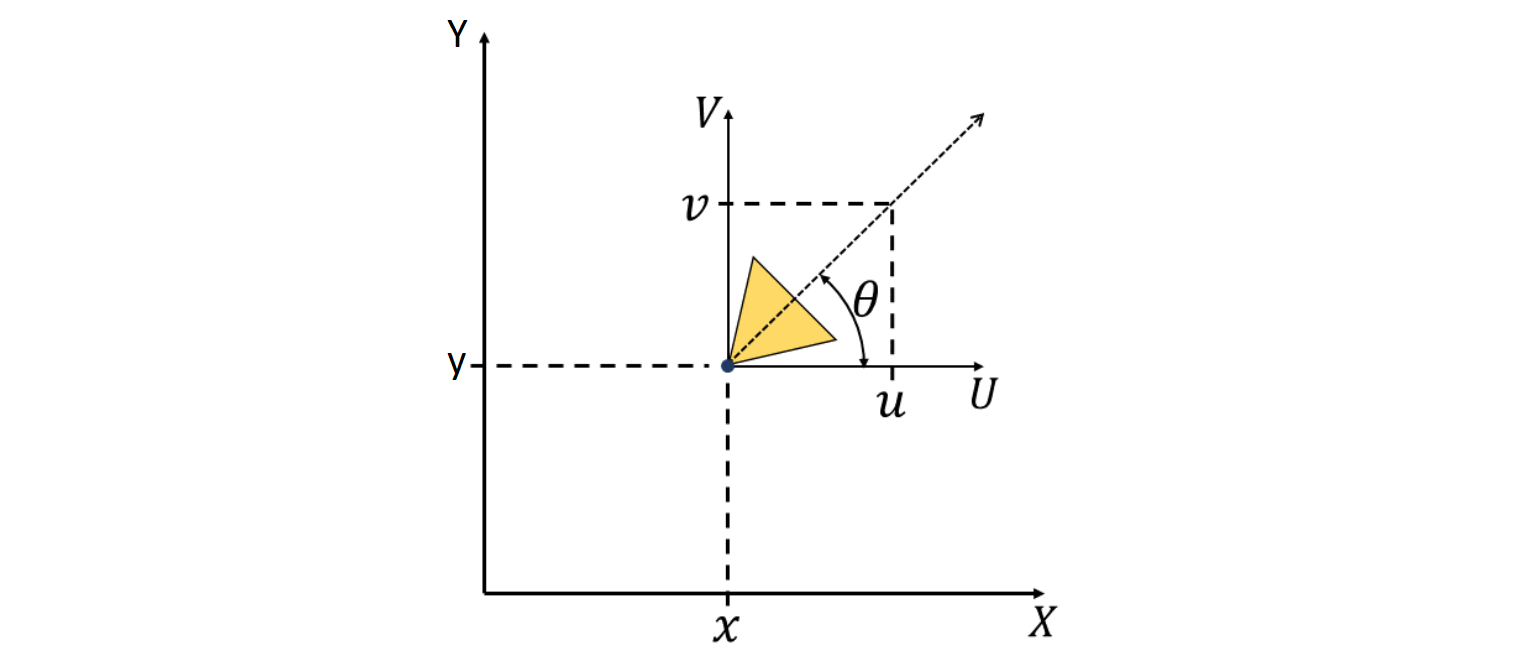

L'immagine seguente mostra alcune immagini prese dal dataset con le corrispondenti posizioni all'interno del supermercato:

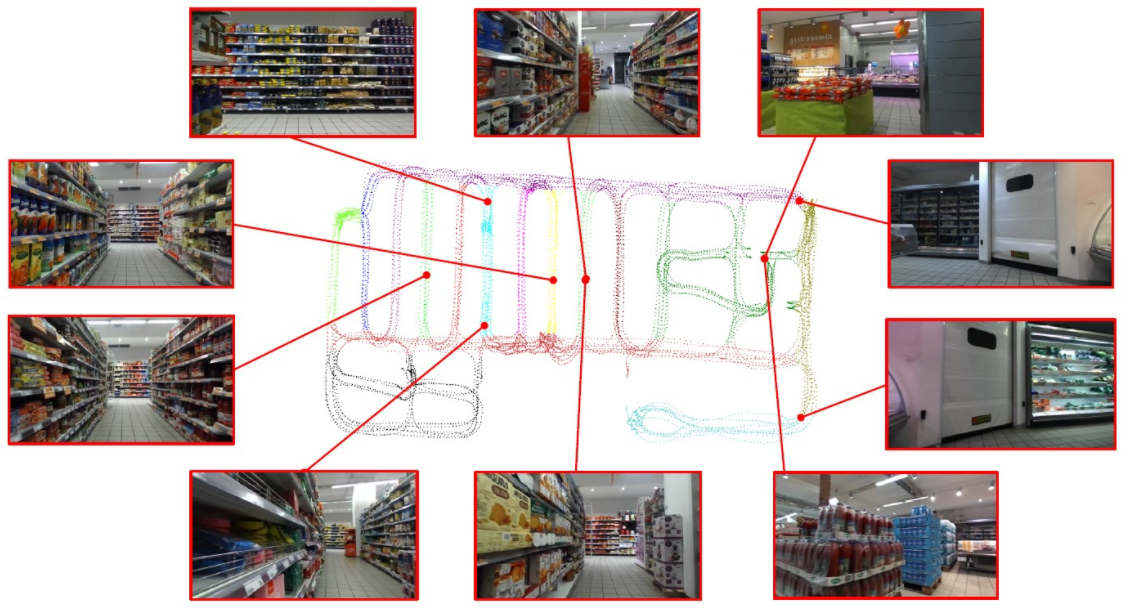

Iniziamo scaricando il dataset con il comando:

`wget https://iplab.dmi.unict.it/EgocentricShoppingCartLocalization/egocart.zip`

Lo zip occupa circa 2.5GB. Una volta scaricato il file, estraiamone il contenuto con:

`unzip egocart.zip -d egocart`.

Dopo aver eseguito questo comando, troveremo le cartelle `train_set`, `test_set` e il file `README.txt`. All'interno di `train_set` sono contenute le cartelle `train_depth` e `train_RGB` e il file `train_set.txt`. Noi utilizeremo solo la cartella `train_RGB`, che contiene le immagini RGB e `train_set.txt` che contiene le etichette (ovvero le posizioni associate a ciascuna immagine). Il test set ha una struttura simile. 

Definiamo un modulo `Dataset` per leggere le immagini e le rispettive etichette da file:

In [19]:
from os.path import join
import numpy as np
from PIL import Image

class EgoCart(data.Dataset):
    def __init__(self, root, mode='train', transform=None):
        self.root = join(root, f"{mode}_set", f"{mode}_RGB")
        self.transform = transform
        
        #leggiamo i nomi dei file e le etichette xy e uv
        labs = np.loadtxt(join(root, f"{mode}_set", f"{mode}_set.txt"), dtype=str)
        self.image_names = labs[:,0]
        self.xy = labs[:,2:4].astype(float)
        self.uv = labs[:,4:6].astype(float)
        
        # normalizziamo uv per assicurarci che siano dei versori
        self.uv/=np.linalg.norm(self.uv,axis=1).reshape(-1,1)
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, i):
        im = Image.open(join(self.root, self.image_names[i]))
        if self.transform is not None:
            im = self.transform(im)
        return im, self.xy[i], self.uv[i]

Visualizziamo qualche esempio di immagine:

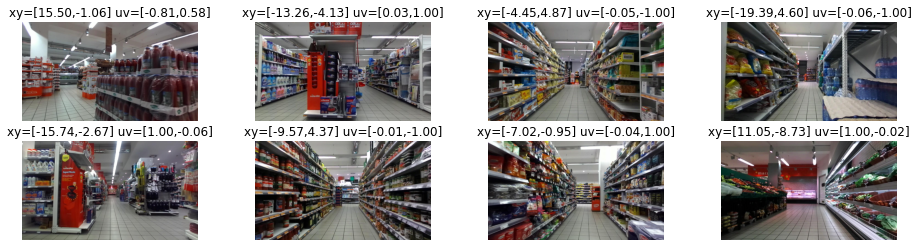

In [20]:
egocart_train = EgoCart(root='egocart')

plt.figure(figsize=(16,4))
for i, idx in enumerate(np.random.choice(len(egocart_train), 8)):
    im, xy, uv = egocart_train[idx]
    plt.subplot(2,4,i+1)
    plt.imshow(im)
    plt.axis('off')
    plt.title("xy=[{x:0.2f},{y:0.2f}] uv=[{u:0.2f},{v:0.2f}]".format(x=xy[0],y=xy[1],u=uv[0],v=uv[1]))
plt.show()

## 3.2 Baseline basata nearest neighbor su RGB

Iniziamo implementando una semplice baseline che effettua una ricerca nearest neighbor basandosi sui valori RGB grezzi. In pratica, questa baseline ricerca l'immagine visivamente più simile. Iniziamo convertendo le immagini RGB in vettori monodimensionali mediante una operazione di reshape:

In [21]:
from tqdm import tqdm
def extract_rgb_representations(loader):
    representations, xy, uv = [], [], []
    for batch in tqdm(loader, total=len(loader)):
        representations.append(batch[0].view(batch[0].shape[0],-1).numpy())
        xy.append(batch[1])
        uv.append(batch[2])
        
    return np.concatenate(representations), np.concatenate(xy), np.concatenate(uv)

Definiamo i dataloader per training e test set. Per questa baseline, considereremo immagini di dimensione $64 \times 64$ per ridurre il numero di feature:

In [22]:
egocart_train_loader = DataLoader(EgoCart(root='egocart',mode='train', 
                        transform=transforms.Compose([
                            transforms.Resize(32),
                            transforms.ToTensor(),
                            # utilizziamo media e deviazione standard fornite per il modello
                            # (sono quelle di imagenet)
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                        ])), shuffle=True, num_workers=8, batch_size=32)

egocart_test_loader = DataLoader(EgoCart(root='egocart',mode='test', 
                        transform=transforms.Compose([
                            transforms.Resize(32),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                        ])), num_workers=8, batch_size=32)

Estraiamo adesso le rappresentazioni per training e test set:

In [23]:
egocart_train_representations_rgb, egocart_train_xy, egocart_train_uv = extract_rgb_representations(egocart_train_loader)
egocart_test_representations_rgb, egocart_test_xy, egocart_test_uv = extract_rgb_representations(egocart_test_loader)

100%|██████████| 193/193 [00:51<00:00,  3.72it/s]


Controlliamo la dimensionalità delle rappresentazioni:

In [24]:
egocart_train_representations_rgb.shape

(13360, 5376)

Costruiamo adesso una funzione che permetta di predire le etichette sul test set utilizzando l'algoritmo nearest neighbor. Utilizzeremo la libreria `faiss` per effettuare la ricerca in maniera efficiente. Da Anaconda, possiamo installare la libreria con il comando:

`conda install -c pytorch faiss-gpu`

Definiamo la funzione:

In [28]:
import faiss
def predict_nn(train_rep, test_rep, train_xy, train_uv):
    # inizializziamo l'oggetto index che utilizzeremo per indicizzare le rappresentazioni
    index = faiss.IndexFlatL2(train_rep.shape[1])
    # aggiungiamo le rappresentazioni di training all'indice
    index.add(train_rep.astype(np.float32))
    # effettuaimo la ricerca

    indices = np.array([index.search(x.reshape(1,-1).astype(np.float32), k=1)[1][0][0] for x in test_rep])
    # restituiamo le etichette predette
    return train_xy[indices].squeeze(), train_uv[indices].squeeze()

Otteniamo le predizioni sul test set:

In [29]:
egocart_pred_test_xy_rgb, egocart_pred_test_uv_rgb = predict_nn(egocart_train_representations_rgb, egocart_test_representations_rgb, egocart_train_xy, egocart_train_uv)

## 3.3 Misure di valutazione

Valuteremo la bontà delle predizioni ottenute calcolando la distanza euclidea tra i vettori `xy` predetti e quelli di ground truth e la distanza angolare media tra gli orientamenti dei vettori `uv`. Definiamo una funzione di valutazione per fare ciò:

In [30]:
def evaluate_localization(pred_xy, pred_uv, gt_xy, gt_uv):
    position_error = np.sqrt(((pred_xy-gt_xy)**2).sum(1)).mean()
    orientation_error = np.rad2deg(np.arccos((gt_uv*pred_uv).sum(1))).mean()
    return position_error, orientation_error

Calcoliamo dunque l'errore di posizione e quello di orientamento:

In [31]:
position_error, orientation_error = evaluate_localization(egocart_pred_test_xy_rgb, egocart_pred_test_uv_rgb, egocart_test_xy, egocart_test_uv)
print(f"Position error: {position_error:0.2f}m")
print(f"Orientation error: {orientation_error:0.2f}°")

Position error: 1.66m
Orientation error: 11.82°


<div>
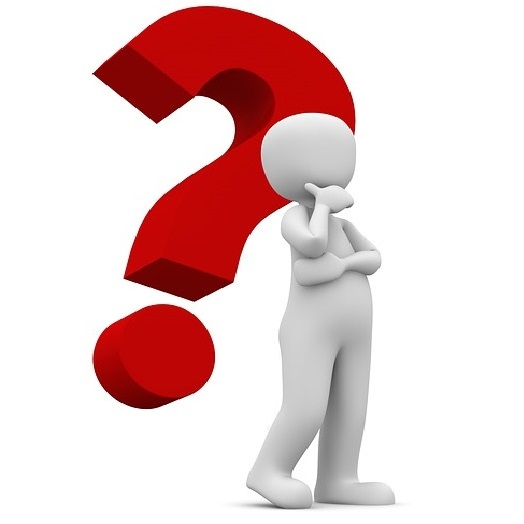
</div>

**Domanda 7**

Si discutano le perfomance della baseline. Si tratta di buone performance?

<div>
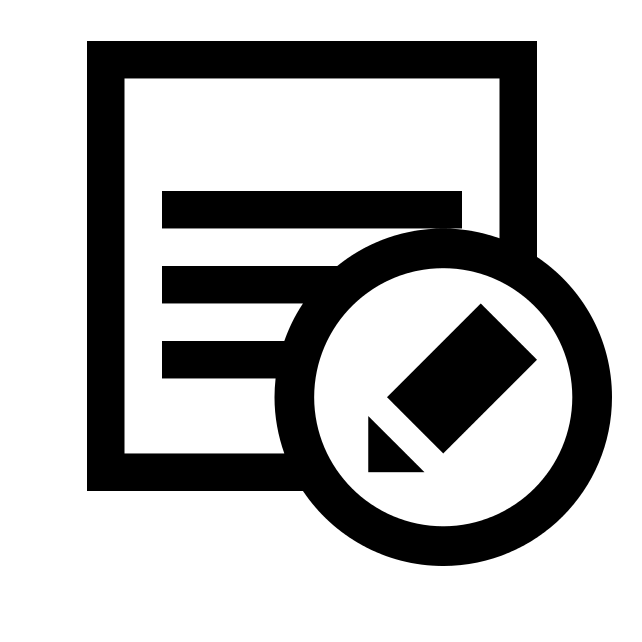
</div>

**Risposta 7**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

## 3.4 Training della funzione di rappresentazione mediante triplet

Vedremo adesso come effettuare il training di una funzione di rappresentazione mediante loss triplet. Utilizzeremo una `MobileNetv2` pre-allenata per estrarre le feature. Utilizzeremo poi l'algoritmo Nearest Neighbor per risolvere il problema di localizzazione. Importiamo il modello:



In [32]:
from torchvision.models import  mobilenet_v2
base_model = mobilenet_v2()

Vogliamo utilizzare il modello per estrarre le feature, quindi dobbiamo rimuovere il classificatore finale. Nello specifico, imposteremo il classificatore a un modulo identità:

In [34]:
base_model.classifier = nn.Identity()

Verifichiamo qual è la dimensione del vettore di feature estratto per una immagine di input di shape $3 \times 224 \times 224$:

In [37]:
base_model(torch.zeros(1,3,224,224)).shape

torch.Size([1, 1280])

Il modello estrae vettori di rappresentazione di $1080$ unità. Definiamo una funzione per estrarre le rappresentazioni dai dataloader di training e test:

In [38]:
from tqdm import tqdm
def extract_representations(model, loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    model.to(device)
    representations, xy, uv = [], [], []
    for batch in tqdm(loader, total=len(loader)):
        x = batch[0].to(device)
        rep = model(x)
        rep = rep.detach().to('cpu').numpy()
        xy.append(batch[1])
        uv.append(batch[2])
        representations.append(rep)
    return np.concatenate(representations), np.concatenate(xy), np.concatenate(uv)

Definiamo i dataloader per training e test set:

In [39]:
egocart_train_loader = DataLoader(EgoCart(root='egocart',mode='train', 
                        transform=transforms.Compose([
                            transforms.Resize(224),
                            transforms.ToTensor(),
                            # utilizziamo media e deviazione standard fornite per il modello
                            # (sono quelle di imagenet)
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                        ])), shuffle=True, num_workers=8, batch_size=32)

egocart_test_loader = DataLoader(EgoCart(root='egocart',mode='test', 
                        transform=transforms.Compose([
                            transforms.Resize(224),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                        ])), num_workers=8, batch_size=32)

Usiamo il modello non ancora allenato per estrarre le rappresentazioni dal training e dal test set:

In [40]:
egocart_train_representations_base, egocart_train_xy, egocart_train_uv = extract_representations(base_model, egocart_train_loader)
egocart_test_representations_base, egocart_test_xy, egocart_test_uv = extract_representations(base_model, egocart_test_loader)

100%|██████████| 193/193 [00:20<00:00,  9.27it/s]


Valutiamo adesso le performance del sistema con queste rappresentazioni non ancora ottimizzate:

In [41]:
egocart_pred_test_xy_base, egocart_pred_test_uv_base = predict_nn(egocart_train_representations_base, egocart_test_representations_base, egocart_train_xy, egocart_train_uv)

position_error, orientation_error = evaluate_localization(egocart_pred_test_xy_base, egocart_pred_test_uv_base, egocart_test_xy, egocart_test_uv)
print(f"Position error: {position_error:0.2f}m")
print(f"Orientation error: {orientation_error:0.2f}°")

Position error: 4.41m
Orientation error: 36.01°


<div>
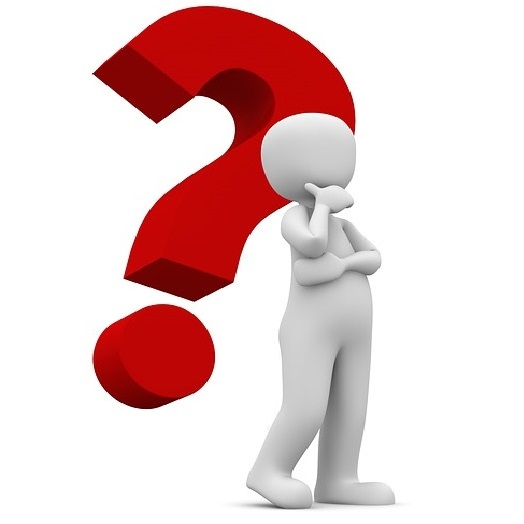
</div>

**Domanda 8**

Si confrontino le performance ottenute con quelle del modello di base che usa i valori RGB come rappresentazione. Si tratta di buone performance? Perché?

<div>
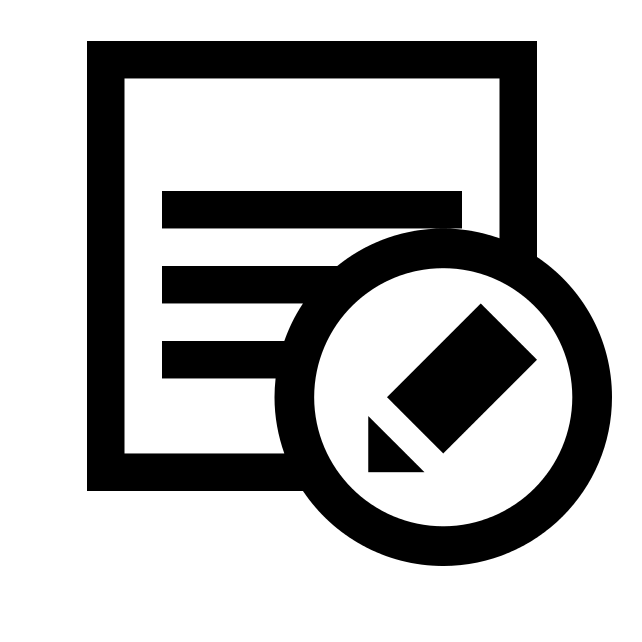
</div>

**Risposta 8**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Procediamo adesso ad allenare la rete mediante Triplet. Per fare ciò, definiremo delle triplette di immagini dal dataset in cui la coppia simile è composta di immagini la cui posizione `xy` ha una distanza inferiore a $0.3m$ e una differenza angolare tra gli orientamenti inferiore a $45°$. Iniziamo costruendo un oggetto dataset che ci permetta di campionare le triplette:

In [42]:
from sklearn.metrics.pairwise import pairwise_distances

class TripletEgoCart(data.Dataset):
    def __init__(self, dataset, min_dist=0.3, min_orient=45):
        self.dataset = dataset
        
        # recuperiamo le etichette xy e uv
        xy = self.dataset.xy
        uv = self.dataset.uv

        # calcoliamo una matrice di milarità per distanze
        xy_similar = pairwise_distances(xy)<min_dist
        # matrice di similarità per orientamento
        uv_similar = np.arccos(1-pairwise_distances(uv, metric='cosine'))<np.deg2rad(min_orient)
        # mettendo in and le due matrici, otteniamo una matrice di similarità
        # in presenza di "true" abbiamo una coppia simile, mentre in presenza di "false" 
        # abbiamo una coppia dissimile
        self.similar = xy_similar & uv_similar
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, i):
        # pivot
        I_i, xy, uv = self.dataset[i]
        # campioniamo un indice simile
        j = np.random.choice(np.where(self.similar[i])[0])
        I_j,*_ = self.dataset[j]
        # campioniamo un indice dissimile
        k = np.random.choice(np.where(~self.similar[i])[0])
        I_k,*_ = self.dataset[k]
        return I_i, I_j, I_k, np.concatenate([xy, uv])

Instanziamo l'oggetto dataset:

In [43]:
egocart_train = EgoCart(root='egocart')
triplet_egocart_train = TripletEgoCart(egocart_train)

Visualizziamo adesso alcuni esempi di triplet:

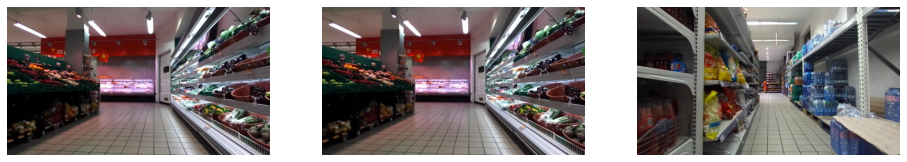

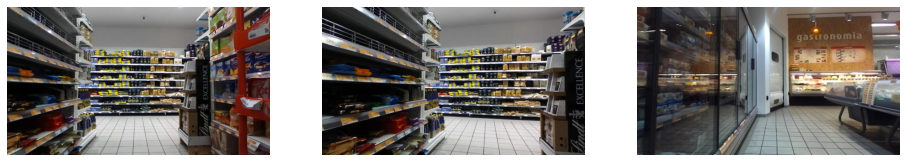

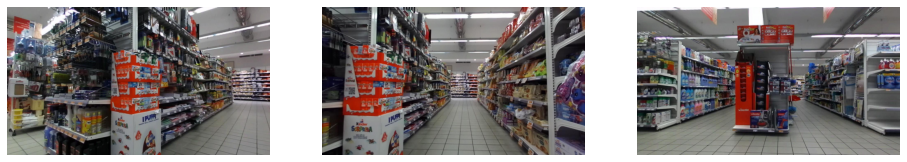

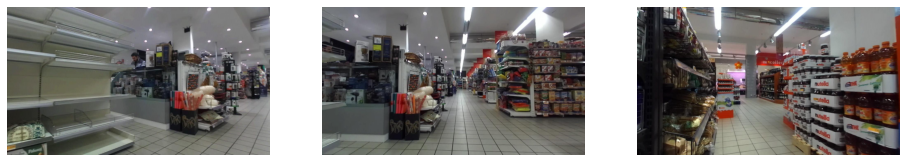

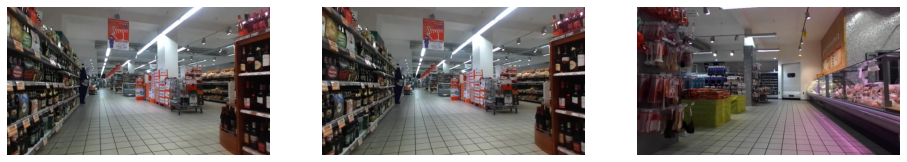

In [44]:
for i in np.random.choice(len(triplet_egocart_train), 5):
    I_i, I_j, I_k, *_ = triplet_egocart_train[i]
    plt.figure(figsize=(16,4))
    plt.subplot(131)
    plt.imshow(I_i)
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(I_j)
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(I_k)
    plt.axis('off')

<div>
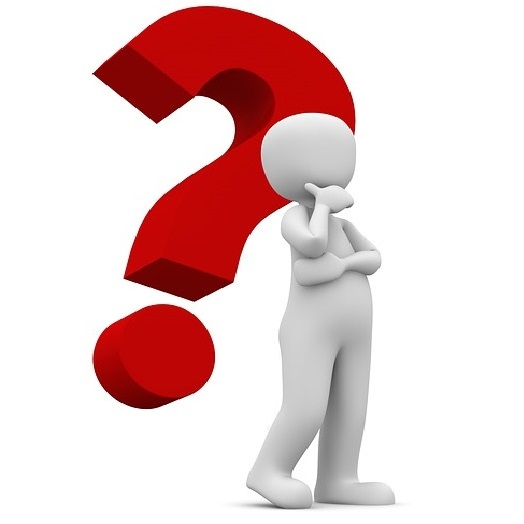
</div>

**Domanda 9**

Si discutano gli esempi di triplet mostrati. Sono esempi validi? Si possono notare differenze visibili tra coppie di immagini simili e dissimili?

<div>
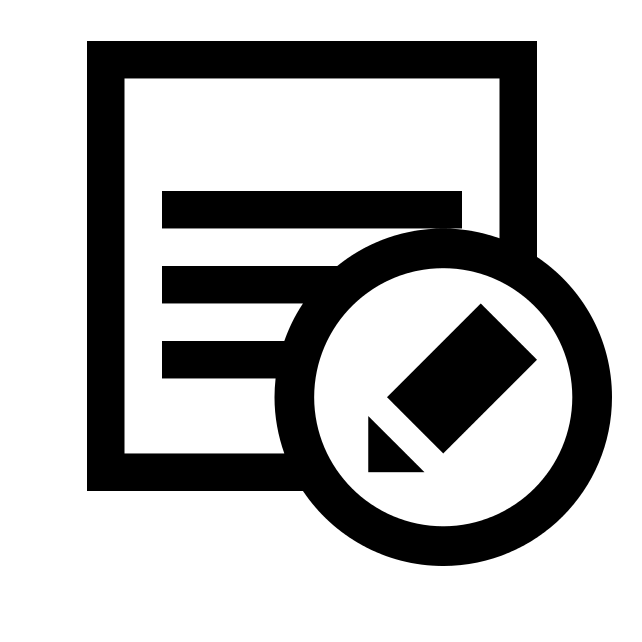
</div>

**Risposta 9**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Definiamo i dataloader di training e test:

In [45]:
egocart_train = EgoCart(root='egocart',mode='train', 
                        transform=transforms.Compose([
                            transforms.Resize(224),
                            transforms.ToTensor(),
                            # utilizziamo media e deviazione standard fornite per il modello
                            # (sono quelle di imagenet)
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                        ]))

egocart_test = EgoCart(root='egocart',mode='test', 
                        transform=transforms.Compose([
                            transforms.Resize(224),
                            transforms.ToTensor(),
                            # utilizziamo media e deviazione standard fornite per il modello
                            # (sono quelle di imagenet)
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                        ]))


triplet_egocart_train_loader = DataLoader(TripletEgoCart(egocart_train), shuffle=True, num_workers=8, batch_size=32)
triplet_egocart_test_loader = DataLoader(TripletEgoCart(egocart_test), num_workers=8, batch_size=32)

Vista la complessità del task, aggiungeremo un termine di regolarizzazione che penalizza la rete se questa cerca di produrre embedding di modulo troppo grande. Si tratta di un vincolo simile a quello di sparsità visto nel caso degli autoencoder, che aiuta a ridurre l'overfitting.

La loss di training sarà dunque:

$$ L(I_i, I_j, I_k) + \beta \cdot (||\Phi(I_i)||_2 + ||\Phi(I_j)||_2  + ||\Phi(I_k)||_2 ) $$

Sceglieremo $\beta=0.001$. Ridefiniamo il modulo triplet di lightning con la nuova loss ed eliminiamo la visualizzazione degli embedding su tensorboard:

In [46]:
class TripletNetworkTask(pl.LightningModule):
    def __init__(self, 
                 embedding_net, # la rete di embedding
                 lr=0.01, # il learning rate
                 momentum=0.99, # momentum
                 margin=2 # margine per la loss
                ):
        super(TripletNetworkTask, self).__init__()
        self.save_hyperparameters()
        self.embedding_net = embedding_net
        self.criterion = nn.TripletMarginLoss(margin = margin)
                    
    def forward(self, x):
        return self.model(x)
        
    def configure_optimizers(self):
        return SGD(self.embedding_net.parameters(), self.hparams.lr, momentum=self.hparams.momentum)
    
    def training_step(self, batch, batch_idx):
        I_i, I_j, I_k, *_ = batch
        #l'implementazione della rete triplet è banale quanto quella della rete siamese:
        #eseguiamo la embedding net sui tre input
        phi_i = self.embedding_net(I_i)
        phi_j = self.embedding_net(I_j)
        phi_k = self.embedding_net(I_k)

        #calcoliamo la loss
        loss_triplet = self.criterion(phi_i, phi_j, phi_k)
        
        loss_embedd = phi_i.norm(2) + phi_j.norm(2) + phi_k.norm(2)
        loss = loss_triplet + 0.001 * loss_embedd
        
        self.log('train/loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        I_i, I_j, I_k, xyuv = batch
        phi_i = self.embedding_net(I_i)
        phi_j = self.embedding_net(I_j)
        phi_k = self.embedding_net(I_k)

        #calcoliamo la loss
        loss_triplet = self.criterion(phi_i, phi_j, phi_k)
        
        loss_embedd = phi_i.norm(2) + phi_j.norm(2) + phi_k.norm(2)
        loss = loss_triplet + 0.001 * loss_embedd
        
        self.log('valid/loss', loss)
        return loss

Adesso possiamo utilizzare il modulo di Lightning definito in precedenza per effettuare il training del modello:

In [47]:
# impostiamo un learning rate più basso
triplet_egocart_task = TripletNetworkTask(base_model, lr=0.001)
logger = TensorBoardLogger("metric_logs", name="egocart_triplet")
# validiamo ogni 5 epoche per risparmiare tempo
trainer = pl.Trainer(gpus=1, logger=logger, max_epochs=NUM_EPOCHS, check_val_every_n_epoch=5, enable_progress_bar=False)

trainer.fit(triplet_egocart_task, triplet_egocart_train_loader, triplet_egocart_test_loader)

/home/furnari/miniconda3/envs/dl/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name          | Type              | Params
----------------------------------------------------
0 | embedding_net | MobileNetV2       | 2.2 M 
1 | criterion     | TripletMarginLoss | 0     
----------------------------------------------------
2.2 M     Trai

RuntimeError: CUDA out of memory. Tried to allocate 34.00 MiB (GPU 0; 15.78 GiB total capacity; 11.26 GiB already allocated; 23.19 MiB free; 11.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Alla fine del training otterremo dei grafici simili ai seguenti su Tensorboard:

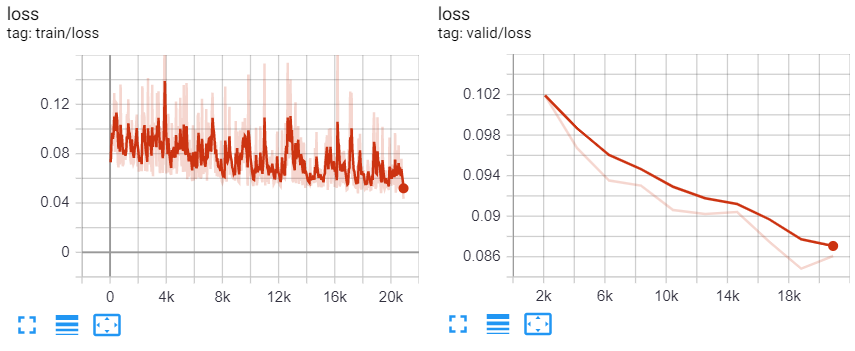

Una volta terminato il training, estraiamo le rappresentazioni e valutiamo il modello:

In [ ]:
egocart_train_representations_triplet, egocart_train_xy, egocart_train_uv = extract_representations(triplet_egocart_task.embedding_net, egocart_train_loader)
egocart_test_representations_triplet, egocart_test_xy, egocart_test_uv = extract_representations(triplet_egocart_task.embedding_net, egocart_test_loader)

egocart_pred_test_xy_triplet, egocart_pred_test_uv_triplet = predict_nn(egocart_train_representations_triplet, egocart_test_representations_triplet, egocart_train_xy, egocart_train_uv)

position_error, orientation_error = evaluate_localization(egocart_pred_test_xy_triplet, egocart_pred_test_uv_triplet, egocart_test_xy, egocart_test_uv)
print(f"Position error: {position_error:0.2f}m")
print(f"Orientation error: {orientation_error:0.2f}°")

<div>
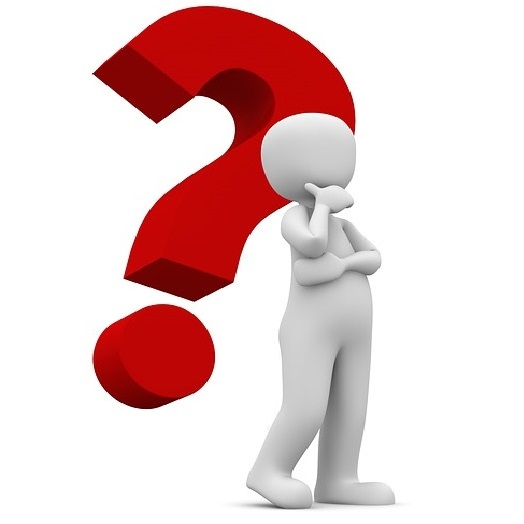
</div>

**Domanda 10**

Si commentino i risultati ottenuti. Sono migliori di quelli ottenuti in precedenza? Perché?

<div>
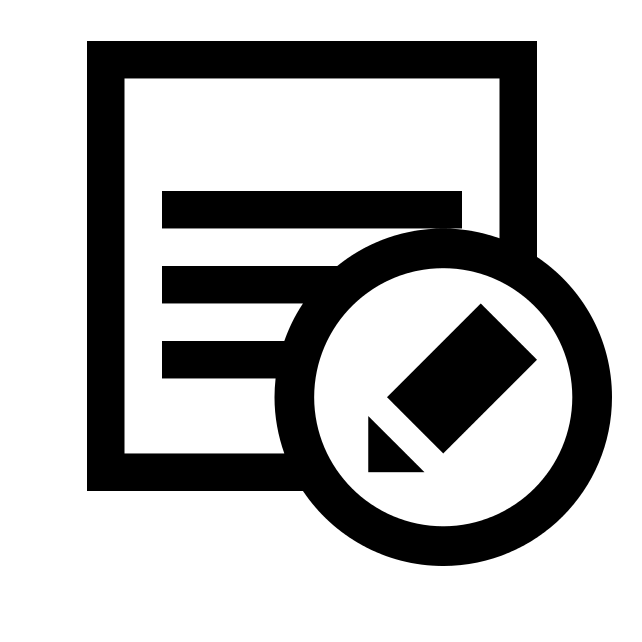
</div>

**Risposta 10**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

# Esercizi

<div>
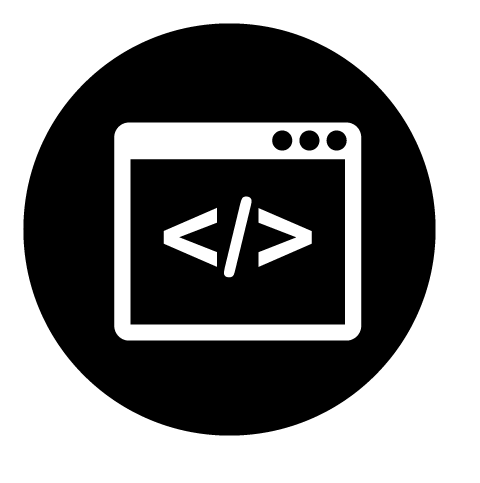
</div>

**Esercizio 1**

Si adatti la EmbeddingNet per effettuare la classificazione dei dati di MNIST e si esegua il fine-tuning per questo task. Si confronti questo modello con un modello analogo allenato da zero. Quale dei due modelli converge prima? Il pre-training mediante rete Siamese offre dei vantaggi?

<div>
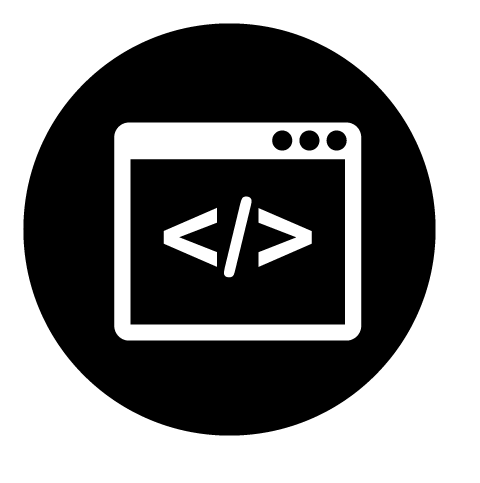
</div>

**Esercizio 2**

Si ripeta l'esecizio precedente adattando la EmbeddingNet allenata mediante rete Triplet per il task di classificazione. Il pre-training mediante rete Triplet offre dei vantaggi? E' più efficace del pre-training mediante rete Siamese? Perché?

<div>
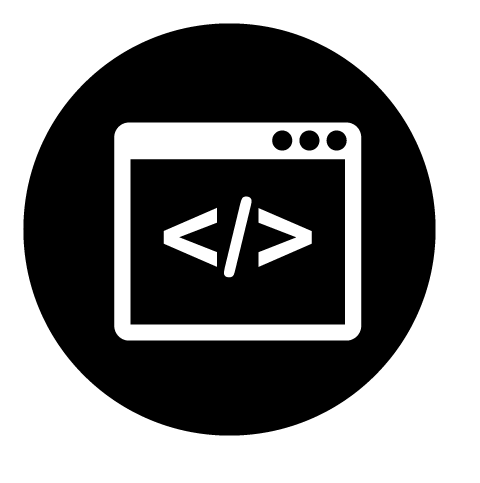
</div>

**Esercizio 3**

Ripetere gli esperimenti su rete siamese con il dataset Fashion MNIST.

<div>
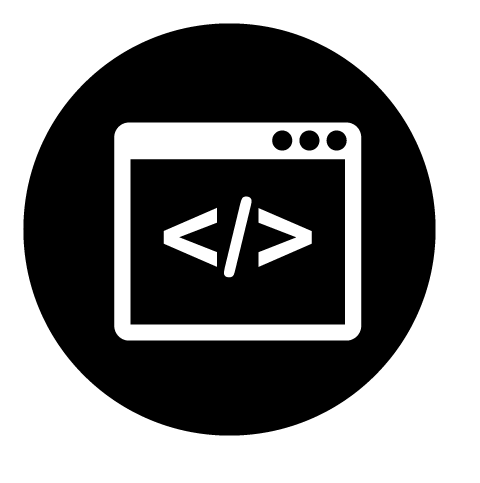
</div>

**Esercizio 4**

Ripetere gli esperimenti su rete triplet con il dataset Fashion MNIST.

<div>
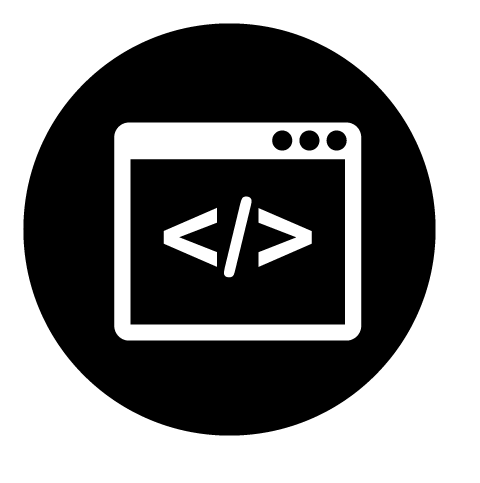
</div>

**Esercizio 5**

Ripetere gli esperimenti di training della rete per localizzazione con triplet cambiando le soglie utilizzate per determinare coppie simili e dissimili e il numero di epoche di training. Provare a trovare dei parametri che permettano di migliorare le performance del modello di localizzazione. Provare a fare fine-tuning di un modello pre-allenato. I risultati migliorano?

# References

 * Documentazione di PyTorch. http://pytorch.org/docs/stable/index.html
 * Documentazione di PyTorch Lightning. https://www.pytorchlightning.ai/